In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import kpss, adfuller, grangercausalitytests
from statsmodels.tsa.api import VAR

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import pmdarima as pm

import warnings
warnings.filterwarnings('ignore')

C:\Users\mimam\AppData\Local\Temp\ipykernel_1716\2864651783.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data = pd.read_csv('./store5.csv')
data['family'].value_counts()

family
AUTOMOTIVE                    1684
HOME APPLIANCES               1684
SCHOOL AND OFFICE SUPPLIES    1684
PRODUCE                       1684
PREPARED FOODS                1684
POULTRY                       1684
PLAYERS AND ELECTRONICS       1684
PET SUPPLIES                  1684
PERSONAL CARE                 1684
MEATS                         1684
MAGAZINES                     1684
LIQUOR,WINE,BEER              1684
LINGERIE                      1684
LAWN AND GARDEN               1684
LADIESWEAR                    1684
HOME CARE                     1684
HOME AND KITCHEN II           1684
BABY CARE                     1684
HOME AND KITCHEN I            1684
HARDWARE                      1684
GROCERY II                    1684
GROCERY I                     1684
FROZEN FOODS                  1684
EGGS                          1684
DELI                          1684
DAIRY                         1684
CLEANING                      1684
CELEBRATION                   1684
BREAD/BAKERY 

In [3]:
data

id        date  store_nbr                      family     sales  \
0         1452  2013-01-01          5                  AUTOMOTIVE     0.000   
1         1453  2013-01-01          5                   BABY CARE     0.000   
2         1454  2013-01-01          5                      BEAUTY     0.000   
3         1455  2013-01-01          5                   BEVERAGES     0.000   
4         1456  2013-01-01          5                       BOOKS     0.000   
...        ...         ...        ...                         ...       ...   
55567  3000586  2017-08-15          5                     POULTRY   241.011   
55568  3000587  2017-08-15          5              PREPARED FOODS    52.121   
55569  3000588  2017-08-15          5                     PRODUCE  1357.823   
55570  3000589  2017-08-15          5  SCHOOL AND OFFICE SUPPLIES     0.000   
55571  3000590  2017-08-15          5                     SEAFOOD     9.669   

       onpromotion  dcoilwtico  
0                0         NaN  
1                0         NaN  
2                0         NaN  
3                0         NaN  
4                0         NaN  
...            ...         ...  
55567            1       47.57  
55568            0       47.57  
55569            4       47.57  
55570            0       47.57  
55571            0       47.57  

[55572 rows x 7 columns]

In [4]:
data.isnull().sum()

id                 0
date               0
store_nbr          0
family             0
sales              0
onpromotion        0
dcoilwtico     17193
dtype: int64

In [5]:
data['dcoilwtico'] = data['dcoilwtico'].ffill()
data['dcoilwtico'].isnull().sum()

33

In [6]:
data['dcoilwtico'] = data['dcoilwtico'].bfill()
data['dcoilwtico'].isnull().sum()

0

# Membuat dataframe baru untuk produk telur

In [7]:
eggs = data.loc[data['family'] == 'EGGS']
eggs = eggs.drop(columns = ['id', 'store_nbr', 'family'])
eggs['date'] = pd.to_datetime(eggs['date'])
eggs = eggs.set_index('date')
eggs

sales  onpromotion  dcoilwtico
date                                      
2013-01-01    0.0            0       93.14
2013-01-02  246.0            0       93.14
2013-01-03  120.0            0       92.97
2013-01-04  141.0            0       93.12
2013-01-05  143.0            0       93.12
...           ...          ...         ...
2017-08-11   95.0           24       48.81
2017-08-12   77.0            0       48.81
2017-08-13  100.0            0       48.81
2017-08-14   85.0            0       47.59
2017-08-15   68.0            0       47.57

[1684 rows x 3 columns]

In [8]:
eggs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1684 entries, 2013-01-01 to 2017-08-15
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sales        1684 non-null   float64
 1   onpromotion  1684 non-null   int64  
 2   dcoilwtico   1684 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 52.6 KB


In [9]:
eggs.describe()

sales  onpromotion   dcoilwtico
count  1684.000000  1684.000000  1684.000000
mean    113.331948     2.636580    67.924899
std      35.562097     6.527131    25.676752
min       0.000000     0.000000    26.190000
25%      87.750000     0.000000    46.377500
50%     109.000000     0.000000    53.410000
75%     132.000000     1.000000    95.720000
max     274.000000    27.000000   110.620000

In [10]:
eggs['year'] = eggs.index.year
eggs['month'] = eggs.index.month
eggs['week'] = eggs.index.isocalendar().week
eggs['day'] = eggs.index.day
eggs['day of the week'] = eggs.index.weekday
eggs['rolling mean'] = eggs['sales'].rolling(window=7).mean()
eggs['rolling std'] = eggs['sales'].rolling(window=7).std()
eggs

sales  onpromotion  dcoilwtico  year  month  week  day  \
date                                                                 
2013-01-01    0.0            0       93.14  2013      1     1    1   
2013-01-02  246.0            0       93.14  2013      1     1    2   
2013-01-03  120.0            0       92.97  2013      1     1    3   
2013-01-04  141.0            0       93.12  2013      1     1    4   
2013-01-05  143.0            0       93.12  2013      1     1    5   
...           ...          ...         ...   ...    ...   ...  ...   
2017-08-11   95.0           24       48.81  2017      8    32   11   
2017-08-12   77.0            0       48.81  2017      8    32   12   
2017-08-13  100.0            0       48.81  2017      8    32   13   
2017-08-14   85.0            0       47.59  2017      8    33   14   
2017-08-15   68.0            0       47.57  2017      8    33   15   

            day of the week  rolling mean  rolling std  
date                                                    
2013-01-01                1           NaN          NaN  
2013-01-02                2           NaN          NaN  
2013-01-03                3           NaN          NaN  
2013-01-04                4           NaN          NaN  
2013-01-05                5           NaN          NaN  
...                     ...           ...          ...  
2017-08-11                4     82.714286    10.688222  
2017-08-12                5     81.571429    10.829853  
2017-08-13                6     82.000000    11.575837  
2017-08-14                0     82.285714    11.629192  
2017-08-15                1     81.714286    12.297890  

[1684 rows x 10 columns]

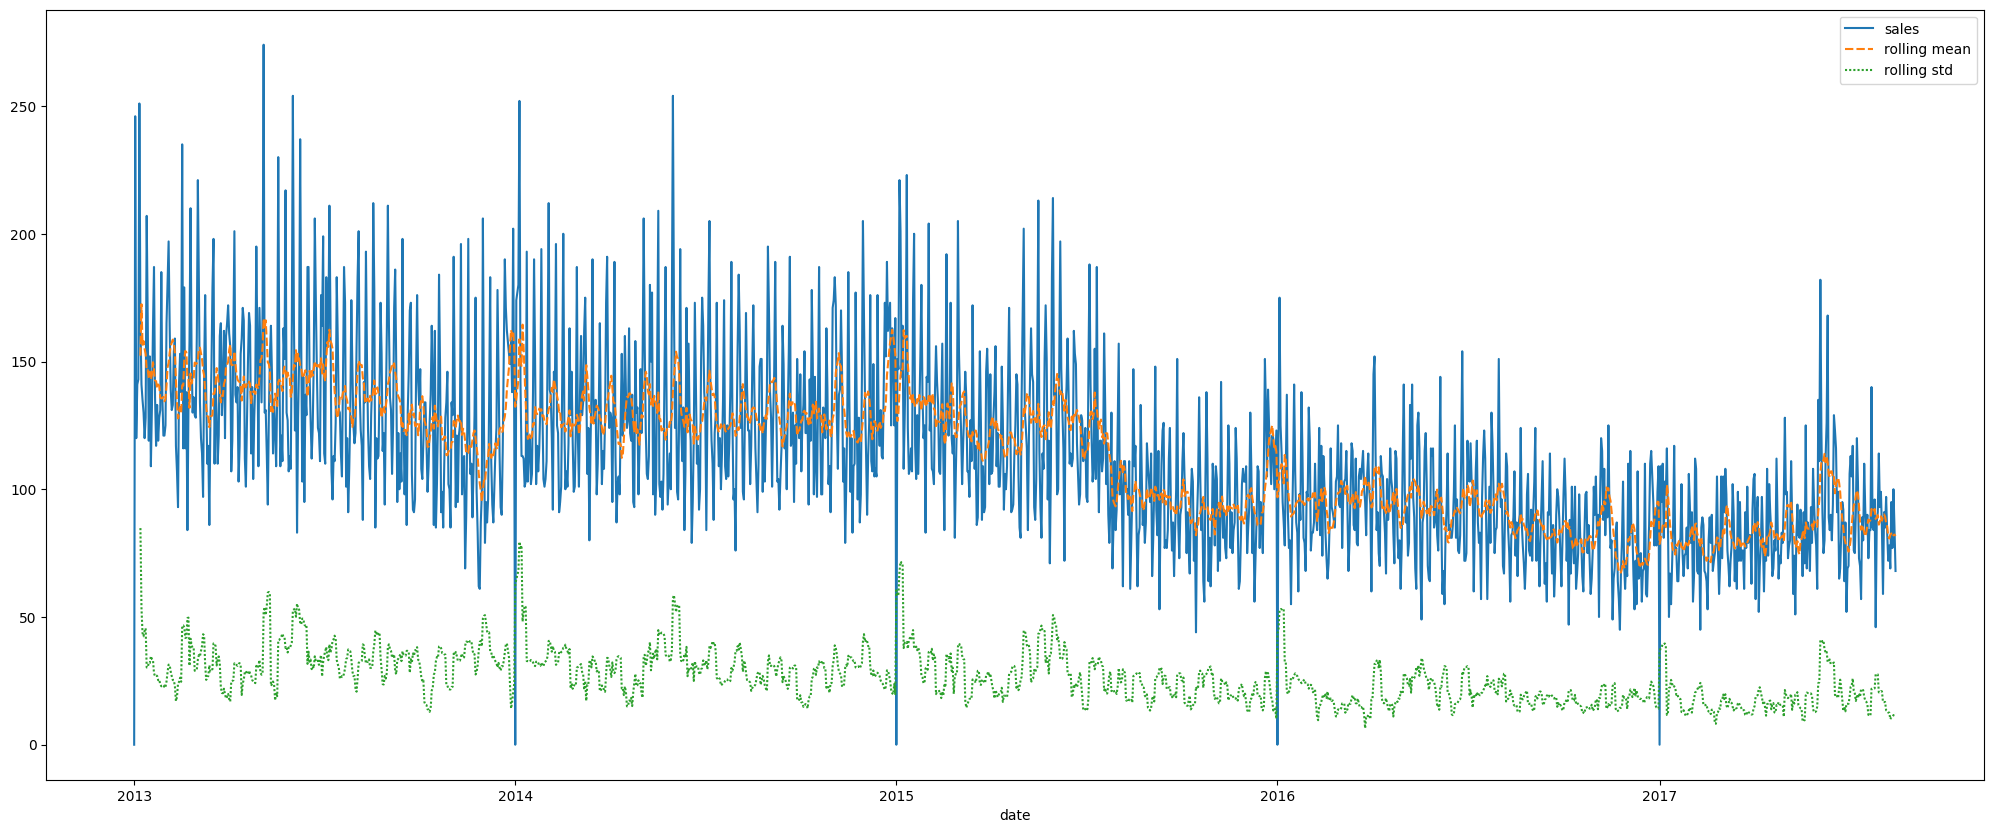

In [11]:
plt.figure(figsize = (25, 10))
sns.lineplot(data = eggs[['sales', 'rolling mean', 'rolling std']])
plt.show()

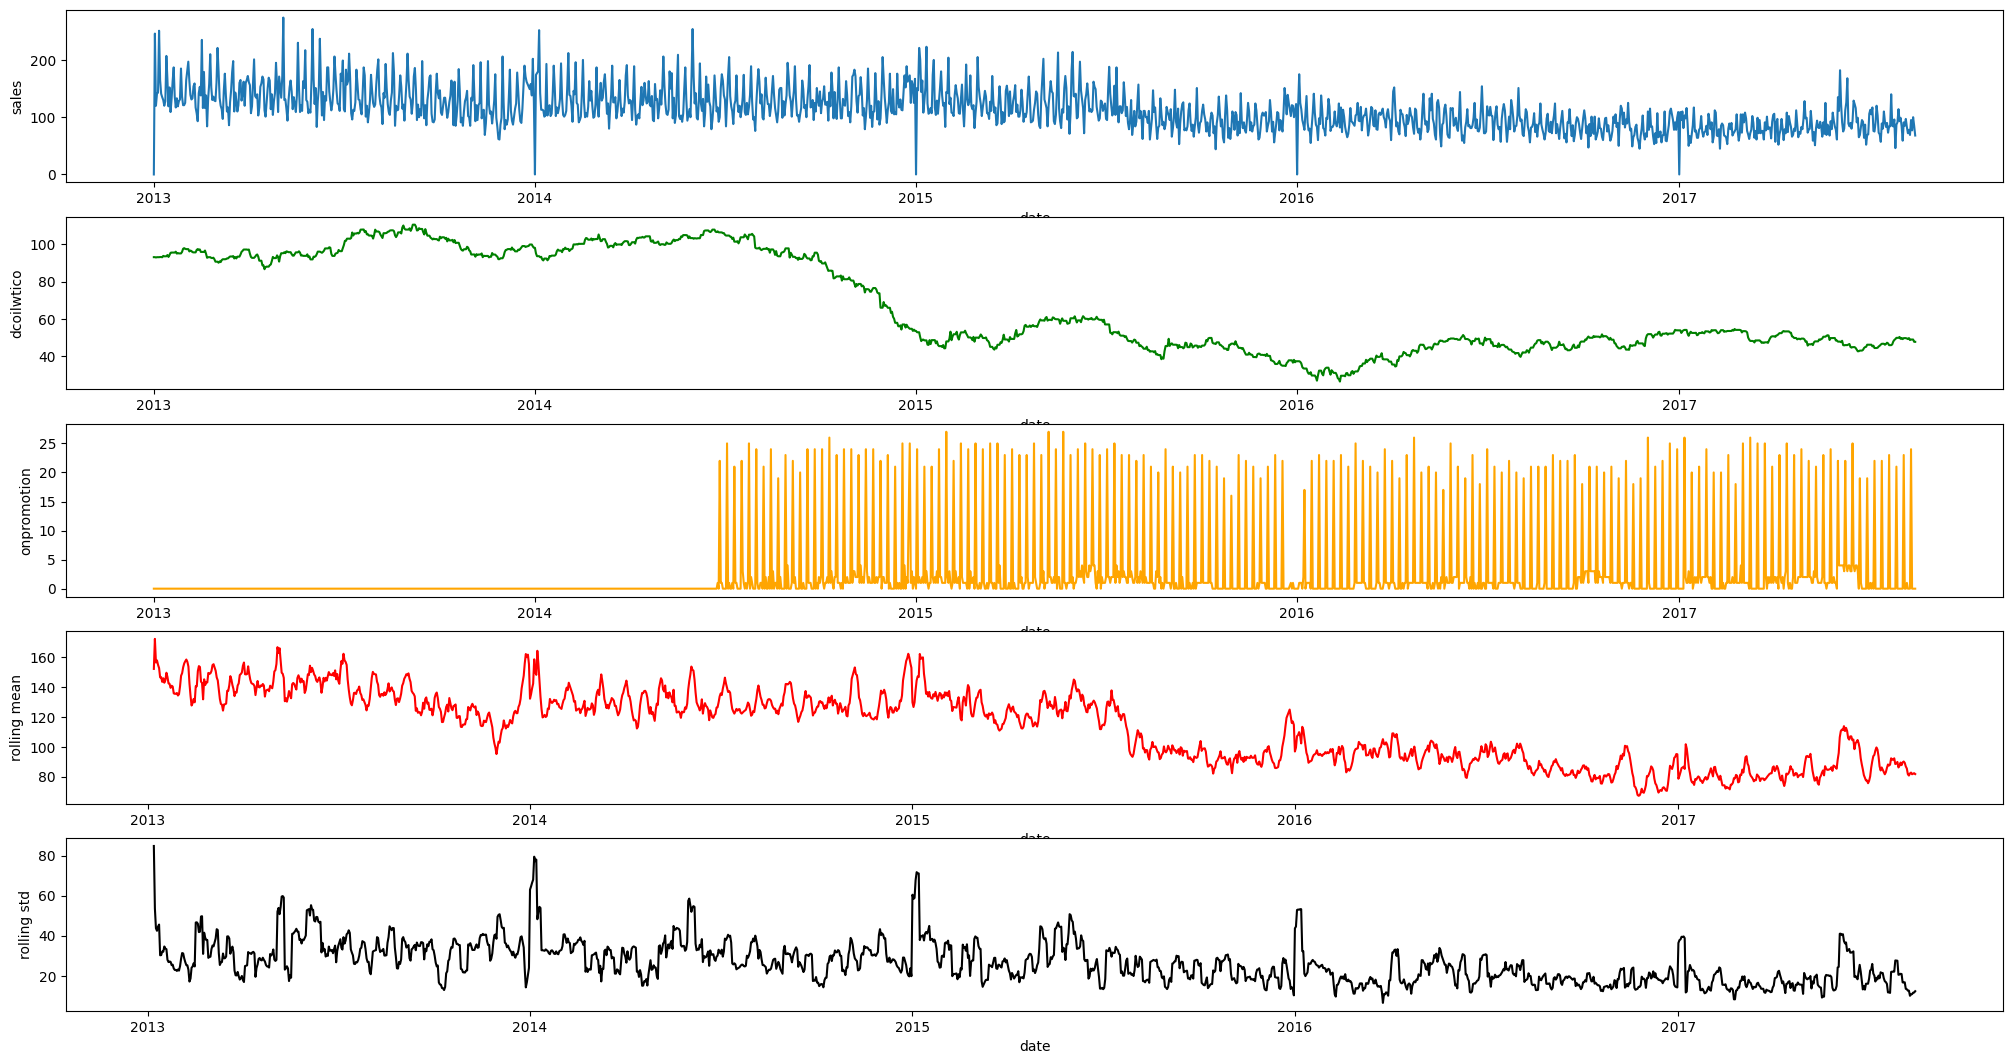

In [58]:
fig, ax = plt.subplots(5, 1, figsize = (25, 13))

sns.lineplot(data=eggs['sales'], ax=ax[0])
sns.lineplot(data=eggs['dcoilwtico'], ax=ax[1], color = 'green')
sns.lineplot(data=eggs['onpromotion'], ax=ax[2], color = 'orange')
sns.lineplot(data=eggs['rolling mean'], ax=ax[3], color = 'red')
sns.lineplot(data=eggs['rolling std'], ax=ax[4], color = 'black')

plt.show()

- Asumsi awal penjualan telur menurun pada pertengahan 2015, kemudian kembali stabil pada tahun 2016 hingga 2017 dan pada setiap tahun baru, toko tidak buka. Data mempunyai tren menurun namun cenderung tidak jelas tren dan seasonalnya
- Dilihat dari rolling mean dan std, time series masih belum terlihat stasioner karena terdapat perubahan nilai yang cukup siginifikan pada beberapa waktu

In [13]:
eggs.loc[eggs['sales'] == 0]

sales  onpromotion  dcoilwtico  year  month  week  day  \
date                                                                 
2013-01-01    0.0            0       93.14  2013      1     1    1   
2014-01-01    0.0            0       98.17  2014      1     1    1   
2015-01-01    0.0            0       53.45  2015      1     1    1   
2016-01-01    0.0            0       37.13  2016      1    53    1   
2017-01-01    0.0            0       53.75  2017      1    52    1   

            day of the week  rolling mean  rolling std  
date                                                    
2013-01-01                1           NaN          NaN  
2014-01-01                2    132.285714    62.983369  
2015-01-01                3    129.857143    60.460534  
2016-01-01                4     96.857143    43.682295  
2017-01-01                6     78.571429    36.381576

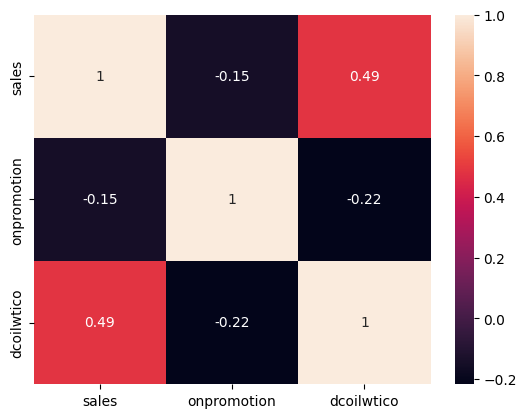

In [14]:
correlation = eggs[['sales', 'onpromotion', 'dcoilwtico']]
correlation = correlation.corr(method = 'pearson')
sns.heatmap(correlation, annot = True)
plt.show()

Berdasarkan plot heatmap, harga minyak berpengaruh terhadap penjualan telur, sedangkan promosi tidak

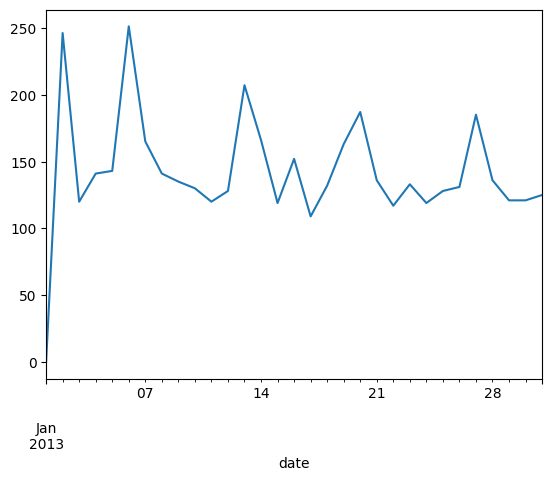

In [15]:
eggs['sales'].head(31).plot()
plt.show()

In [16]:
eggs.head(31)

sales  onpromotion  dcoilwtico  year  month  week  day  \
date                                                                 
2013-01-01    0.0            0       93.14  2013      1     1    1   
2013-01-02  246.0            0       93.14  2013      1     1    2   
2013-01-03  120.0            0       92.97  2013      1     1    3   
2013-01-04  141.0            0       93.12  2013      1     1    4   
2013-01-05  143.0            0       93.12  2013      1     1    5   
2013-01-06  251.0            0       93.12  2013      1     1    6   
2013-01-07  165.0            0       93.20  2013      1     2    7   
2013-01-08  141.0            0       93.21  2013      1     2    8   
2013-01-09  135.0            0       93.08  2013      1     2    9   
2013-01-10  130.0            0       93.81  2013      1     2   10   
2013-01-11  120.0            0       93.60  2013      1     2   11   
2013-01-12  128.0            0       93.60  2013      1     2   12   
2013-01-13  207.0            0       93.60  2013      1     2   13   
2013-01-14  166.0            0       94.27  2013      1     3   14   
2013-01-15  119.0            0       93.26  2013      1     3   15   
2013-01-16  152.0            0       94.28  2013      1     3   16   
2013-01-17  109.0            0       95.49  2013      1     3   17   
2013-01-18  132.0            0       95.61  2013      1     3   18   
2013-01-19  163.0            0       95.61  2013      1     3   19   
2013-01-20  187.0            0       95.61  2013      1     3   20   
2013-01-21  136.0            0       95.61  2013      1     4   21   
2013-01-22  117.0            0       96.09  2013      1     4   22   
2013-01-23  133.0            0       95.06  2013      1     4   23   
2013-01-24  119.0            0       95.35  2013      1     4   24   
2013-01-25  128.0            0       95.15  2013      1     4   25   
2013-01-26  131.0            0       95.15  2013      1     4   26   
2013-01-27  185.0            0       95.15  2013      1     4   27   
2013-01-28  136.0            0       95.95  2013      1     5   28   
2013-01-29  121.0            0       97.62  2013      1     5   29   
2013-01-30  121.0            0       97.98  2013      1     5   30   
2013-01-31  125.0            0       97.65  2013      1     5   31   

            day of the week  rolling mean  rolling std  
date                                                    
2013-01-01                1           NaN          NaN  
2013-01-02                2           NaN          NaN  
2013-01-03                3           NaN          NaN  
2013-01-04                4           NaN          NaN  
2013-01-05                5           NaN          NaN  
2013-01-06                6           NaN          NaN  
2013-01-07                0    152.285714    84.789375  
2013-01-08                1    172.428571    53.590600  
2013-01-09                2    156.571429    43.703002  
2013-01-10                3    158.000000    42.453897  
2013-01-11                4    155.000000    44.545857  
2013-01-12                5    152.857143    45.568368  
2013-01-13                6    146.571429    30.226132  
2013-01-14                0    146.714286    30.329932  
2013-01-15                1    143.571429    32.108447  
2013-01-16                2    146.000000    31.994791  
2013-01-17                3    143.000000    34.621766  
2013-01-18                4    144.714286    33.574367  
2013-01-19                5    149.714286    33.275187  
2013-01-20                6    146.857143    27.972776  
2013-01-21                0    142.571429    26.825716  
2013-01-22                1    142.285714    27.127565  
2013-01-23                2    139.571429    26.943504  
2013-01-24                3    141.000000    25.265259  
2013-01-25                4    140.428571    25.546410  
2013-01-26                5    135.857143    23.625047  
2013-01-27                6    135.571429    22.904564  
2013-01-28                0    135.571429    22.

Saat melakukan analisis pada bulan pertama, terlihat pada hari ke-6 (sabtu), penjualan telur terlihat meningkat dibandingkan pada weekday dan hari minggu

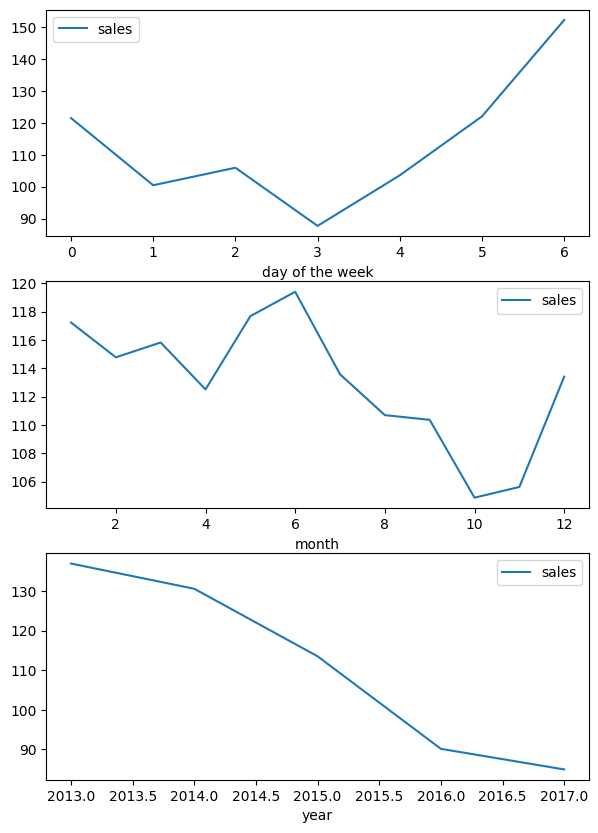

In [17]:
vis1 = eggs.groupby('day of the week')[['sales']].agg('mean')
vis2 = eggs.groupby('month')[['sales']].agg('mean')
vis3 = eggs.groupby('year')[['sales']].agg('mean')

fig, ax = plt.subplots(3, 1, figsize = (7, 10))

sns.lineplot(data = vis1, ax = ax[0])
sns.lineplot(data = vis2, ax = ax[1])
sns.lineplot(data = vis3, ax = ax[2])

plt.show()

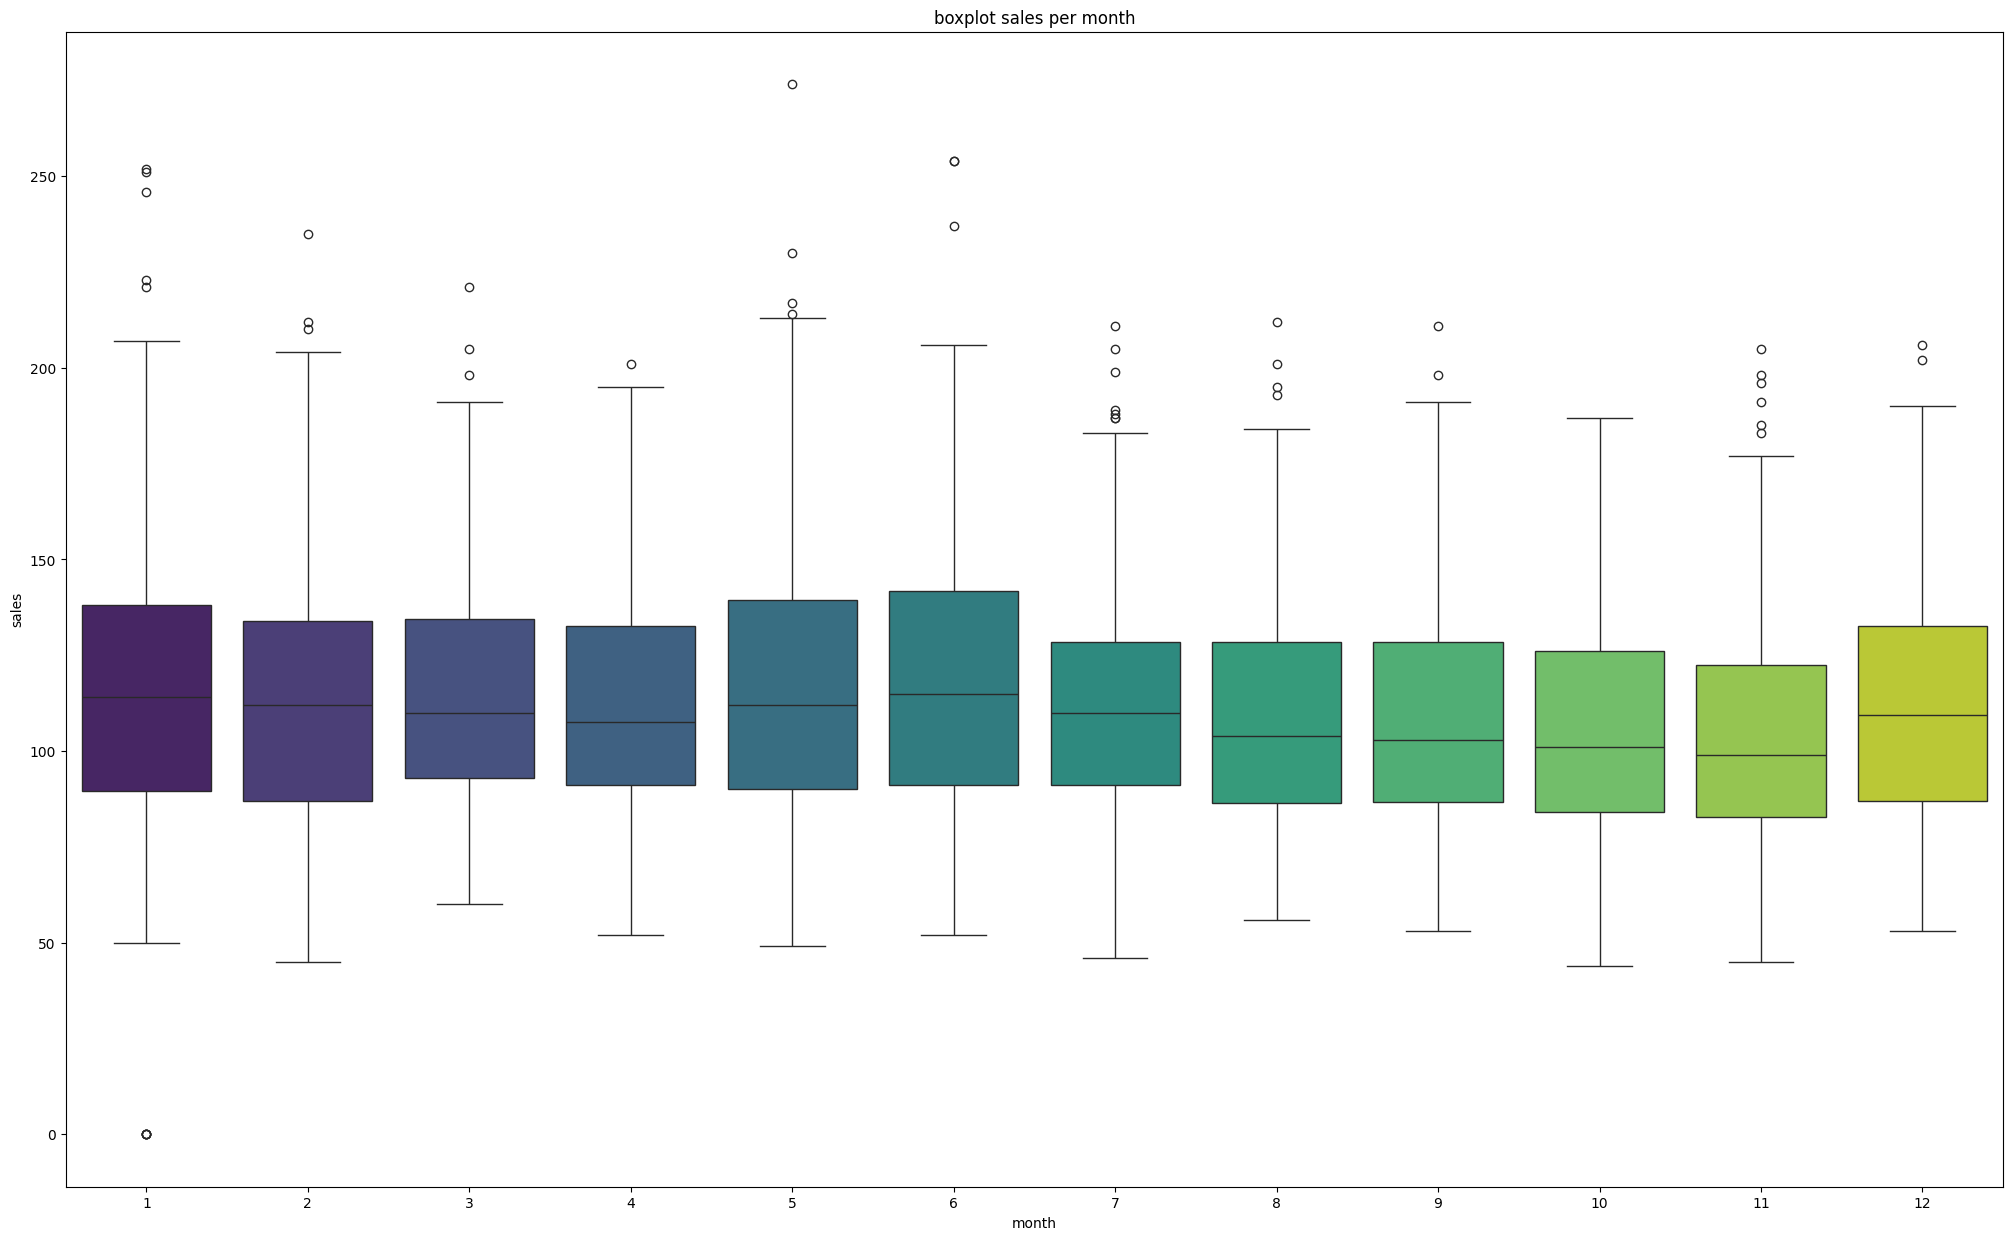

In [18]:
plt.figure(figsize = (25, 15))

sns.boxplot(data = eggs, x = 'month', y = 'sales', palette = 'viridis')
plt.title('boxplot sales per month')
plt.show()

- Outlier terlihat berada di luar batas atas, sedangkan pada batas bawah hanya terdapat pada bulan pertama, dimana toko tidak buka pada tanggal 1
- Distribusi Data terlihat cenderung normal setiap bulannya

# Dekomposisi Time Series

In [19]:
eggs16 = eggs.loc['2016' : '2016']
eggs16

sales  onpromotion  dcoilwtico  year  month  week  day  \
date                                                                 
2016-01-01    0.0            0       37.13  2016      1    53    1   
2016-01-02  120.0            0       37.13  2016      1    53    2   
2016-01-03  175.0            1       37.13  2016      1    53    3   
2016-01-04  125.0            1       36.81  2016      1     1    4   
2016-01-05  114.0            1       35.97  2016      1     1    5   
...           ...          ...         ...   ...    ...   ...  ...   
2016-12-27   78.0            0       52.82  2016     12    52   27   
2016-12-28   91.0            0       54.01  2016     12    52   28   
2016-12-29   78.0            0       53.80  2016     12    52   29   
2016-12-30   99.0           24       53.75  2016     12    52   30   
2016-12-31  109.0            0       53.75  2016     12    52   31   

            day of the week  rolling mean  rolling std  
date                                                    
2016-01-01                4     96.857143    43.682295  
2016-01-02                5     99.428571    44.556545  
2016-01-03                6    107.142857    52.821803  
2016-01-04                0    107.857143    53.057920  
2016-01-05                1    109.857143    52.976185  
...                     ...           ...          ...  
2016-12-27                1     87.857143    20.375055  
2016-12-28                2     92.571429    15.565530  
2016-12-29                3     93.285714    14.602674  
2016-12-30                4     95.142857    14.346063  
2016-12-31                5     95.000000    14.177447  

[365 rows x 10 columns]

<Figure size 3500x1500 with 0 Axes>

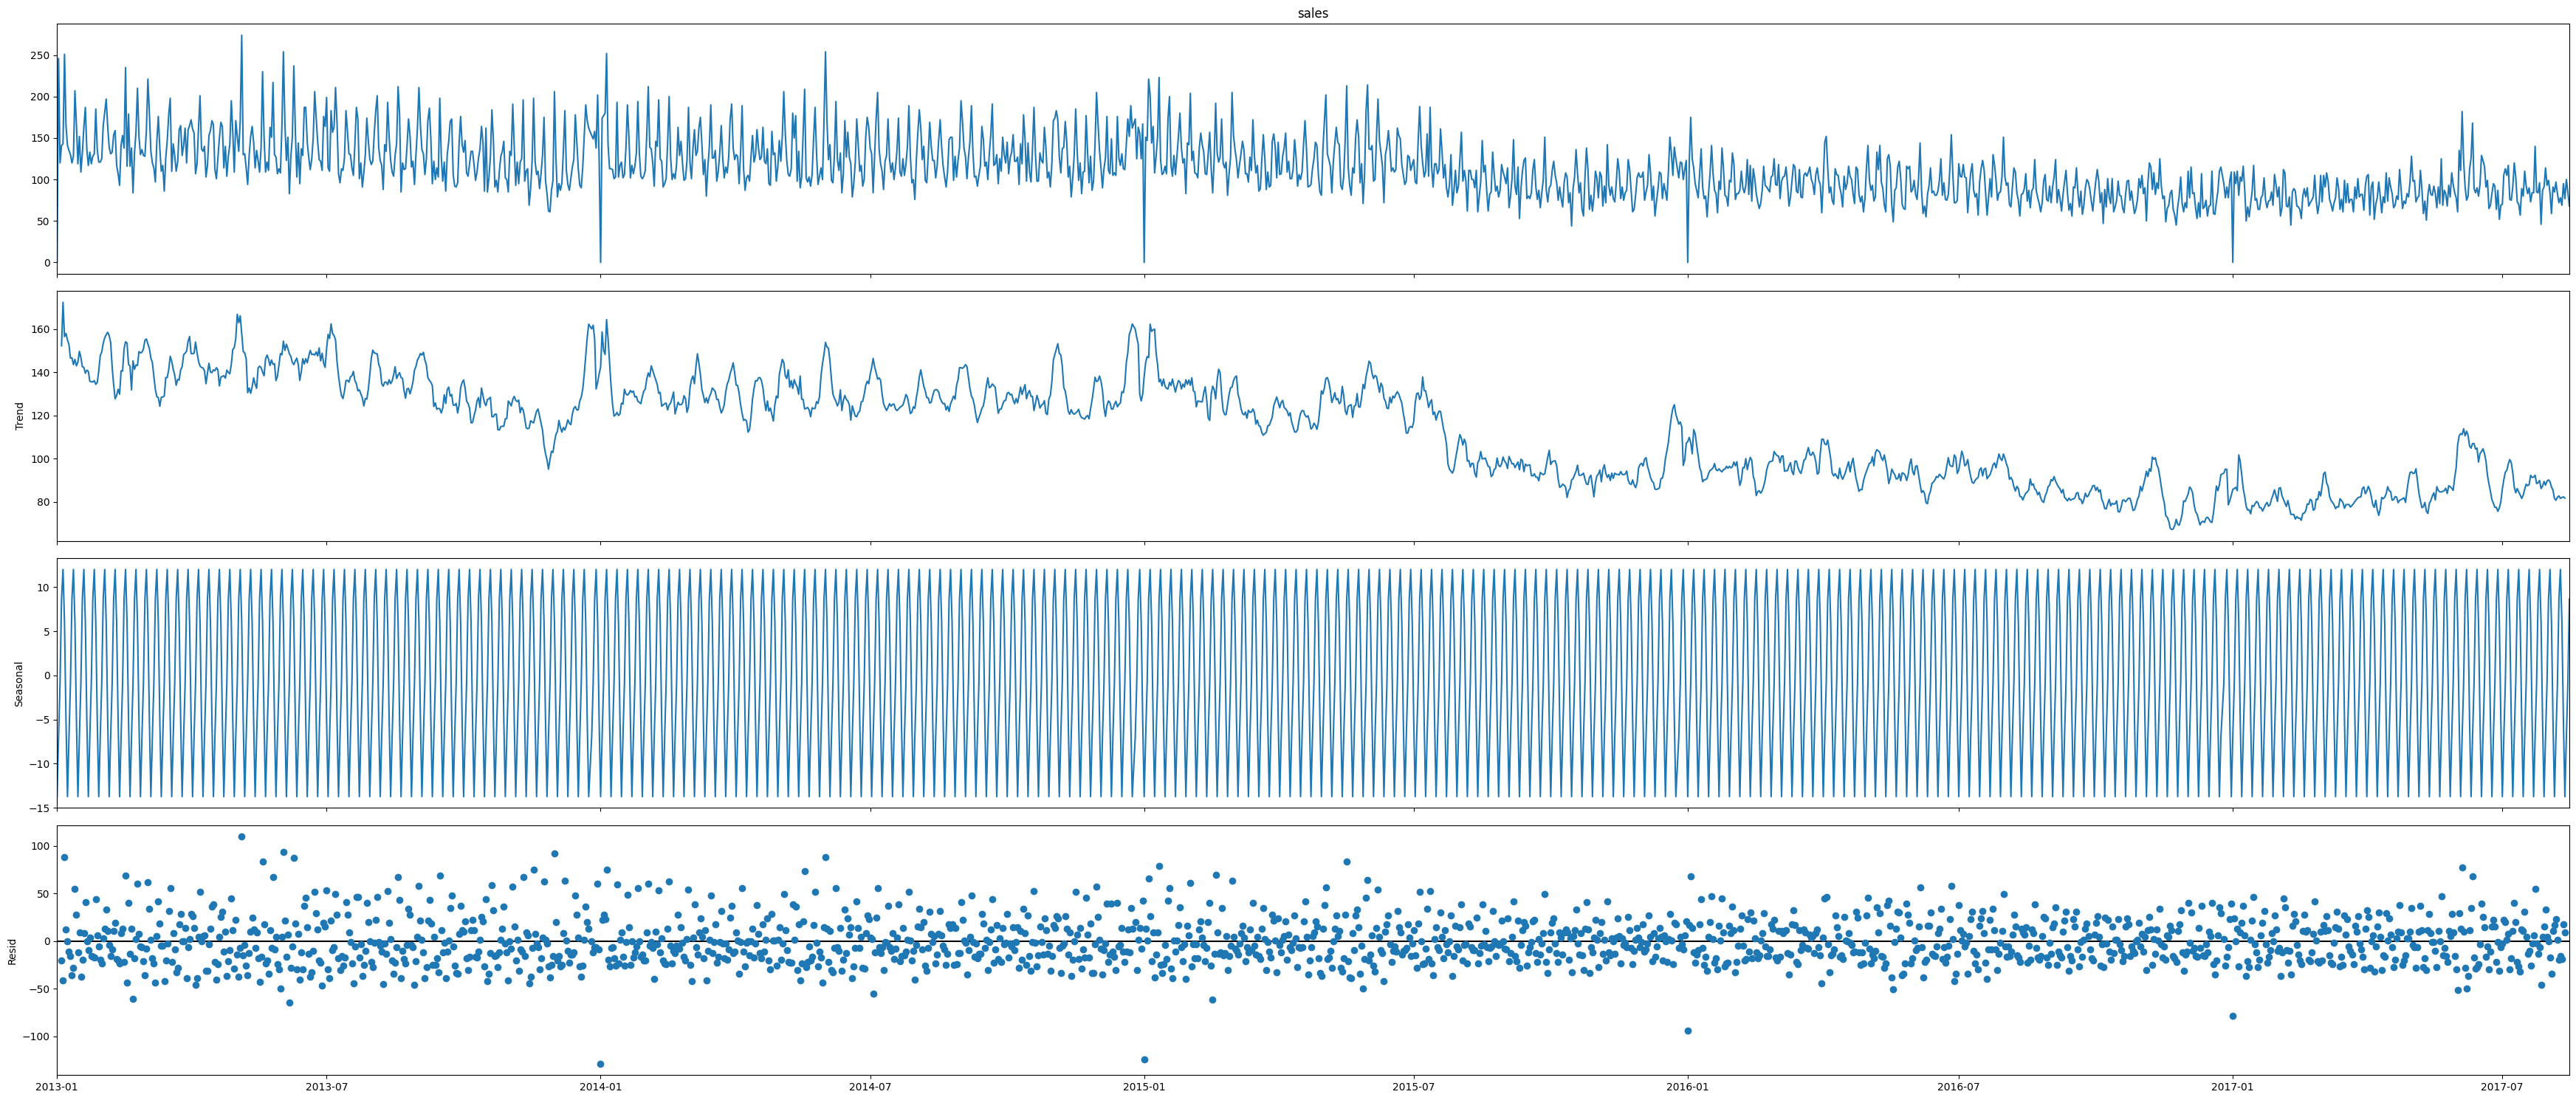

In [64]:
# Make fig size bigger
plt.rcParams['figure.figsize'] = (35, 15)
# Decompose time series
decomposition = seasonal_decompose(eggs['sales'], model = 'additive', period = 7)
fig = plt.figure()
fig = decomposition.plot()

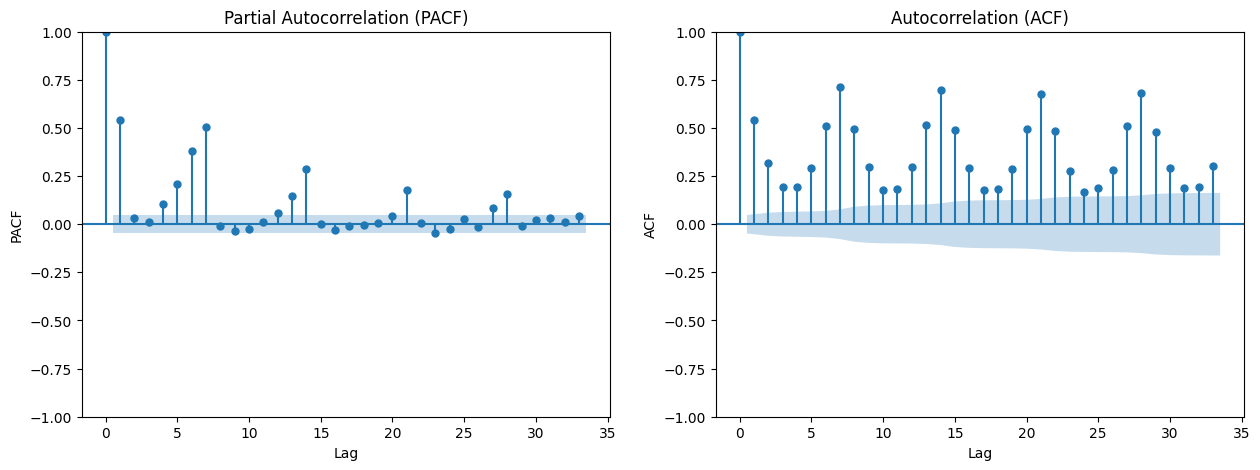

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plot_pacf(eggs['sales'], ax=axes[0])
axes[0].set_title('Partial Autocorrelation (PACF)')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('PACF')

plot_acf(eggs['sales'], ax=axes[1])
axes[1].set_title('Autocorrelation (ACF)')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('ACF')

plt.show()

# ADF & KPSS Test

In [22]:
result = adfuller(eggs['sales'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.860447
p-value: 0.350891


In [23]:
result = kpss(eggs['sales'])

print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])

KPSS Statistic: 6.673613
p-value: 0.010000


Dari uji KPSS dan ADF, uji ADF menunjukkan bahwa time series bersifat non-stasioner dan KPPS juga bersifat non-stasioner

In [24]:
result = adfuller(eggs['sales'].diff().dropna())

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -12.485285
p-value: 0.000000


In [25]:
result = kpss(eggs['sales'].diff().dropna())

print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])

KPSS Statistic: 0.141552
p-value: 0.100000


Timeseries terlihat sudah stasioner setelah dilakukan differencing sekali, dimana p-value dari dari tes ADF menunjukkan kurang dari 0.05 yang berarti data sudah stasioner, sedangkan pada tes KPSS p-value lebih dari 0.05 yang menunjukkan memilikki tren, namun tidak berpengaruh terhadap non-stasioner dari timeseries

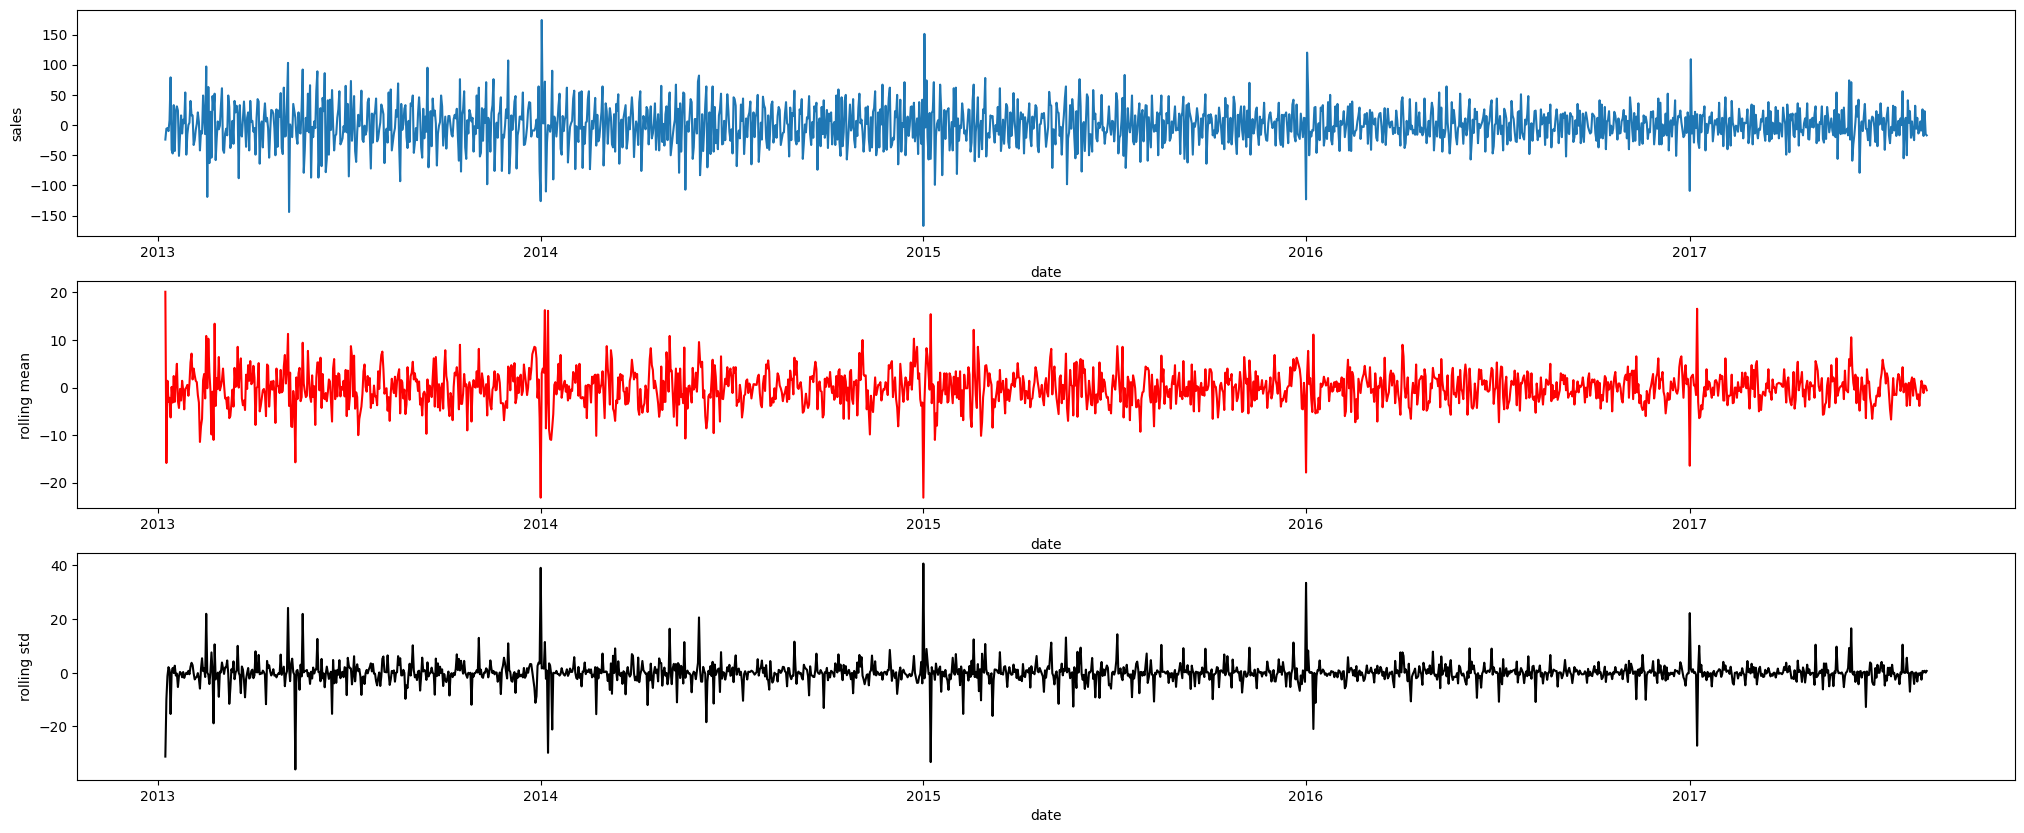

In [26]:
eggs_diff = eggs[['sales', 'rolling mean', 'rolling std']].diff().dropna()

fig, ax = plt.subplots(3, 1, figsize = (25, 10))

sns.lineplot(data=eggs_diff['sales'], ax=ax[0])
sns.lineplot(data=eggs_diff['rolling mean'], ax=ax[1], color = 'red')
sns.lineplot(data=eggs_diff['rolling std'], ax=ax[2], color = 'black')

plt.show()

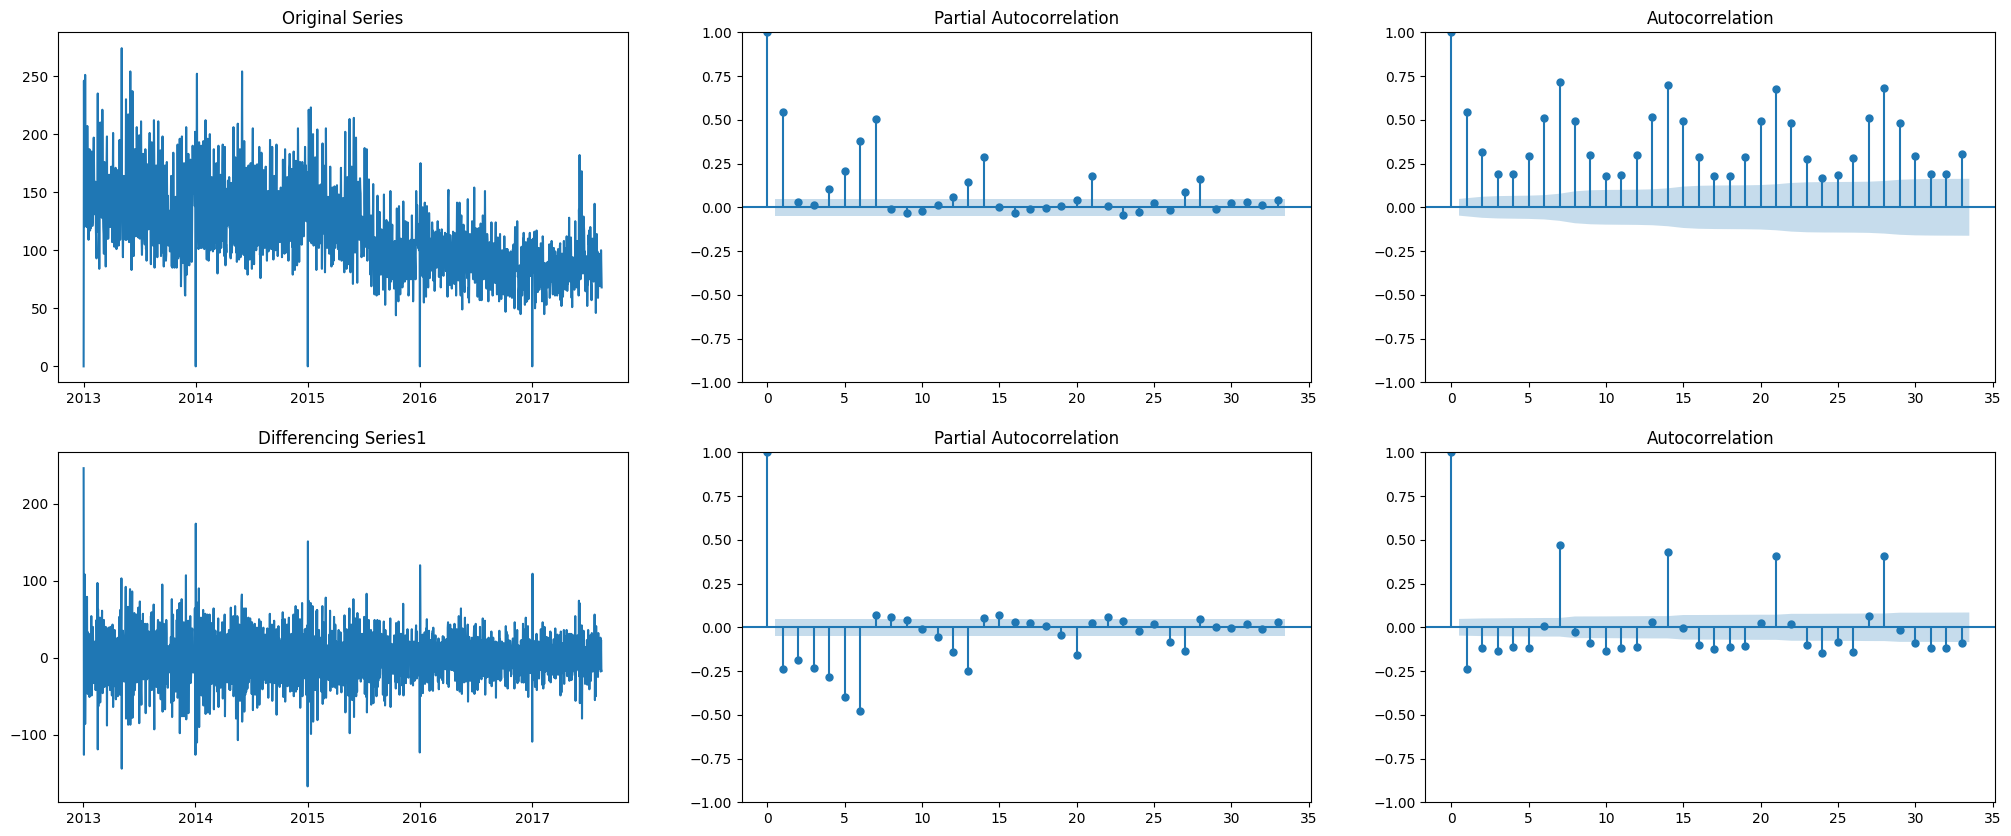

In [27]:
fig, ax = plt.subplots(2, 3, figsize=(25, 10))

ax[0, 0].set_title('Original Series')
ax[0, 0].plot(eggs['sales'])
ax[0, 1] = plot_pacf(eggs['sales'], ax=ax[0, 1])
ax[0, 2] = plot_acf(eggs['sales'], ax=ax[0, 2])

ax[1, 0].set_title('Differencing Series1')
ax[1, 0].plot(eggs['sales'].diff().dropna())
ax[1, 1] = plot_pacf(eggs['sales'].diff().dropna(), ax=ax[1, 1])
ax[1, 2] = plot_acf(eggs['sales'].diff().dropna(), ax=ax[1, 2])

plt.show()

seasonal = ARIMA(2,1,1) (1,1,2) [7]

# Modelling

In [28]:
train = eggs['sales'][:len(eggs)-30]
test = eggs['sales'][len(eggs)-30:]

In [29]:
'''
model = pm.auto_arima(train,
                      start_p=1,        # nilai p pertama
                      start_q=1,        # nilai q pertama
                      test='adf',       # gunakan adftest untuk mencari optimal 'd'
                      max_p=6,          # maksimal p
                      max_q=6,          # maksimal q
                      d=1,           # let model determine 'd'
                      m=7,             # frequency of serie
                      seasonal=True,    # Seasonality
                      start_P=1,        # nilai P pertama
                      D=1,           # let model determine 'D'
                      start_Q=1,        # nilai Q pertama
                      max_P=6,          # maksimal P
                      max_D=1,          # maksimal D
                      max_Q=6,          # maksimal Q
                      trace=True,       # print result
                      error_action='ignore',    # we don't want to know if an order does not work
                      suppress_warnings=True,   # we don't want convergence warnings
                      stepwise=True)        # set to stepwise

print(model.summary())
'''

"\nmodel = pm.auto_arima(train,\n                      start_p=1,        # nilai p pertama\n                      start_q=1,        # nilai q pertama\n                      test='adf',       # gunakan adftest untuk mencari optimal 'd'\n                      max_p=6,          # maksimal p\n                      max_q=6,          # maksimal q\n                      d=1,           # let model determine 'd'\n                      m=7,             # frequency of serie\n                      seasonal=True,    # Seasonality\n                      start_P=1,        # nilai P pertama\n                      D=1,           # let model determine 'D'\n                      start_Q=1,        # nilai Q pertama\n                      max_P=6,          # maksimal P\n                      max_D=1,          # maksimal D\n                      max_Q=6,          # maksimal Q\n                      trace=True,       # print result\n                      error_action='ignore',    # we don't want to know if a

In [30]:
from statsmodels.tsa.arima.model import ARIMA

# Seasonal ARIMA Model
# model = ARIMA(train, order=(1,1,1), seasonal_order=(2,1,1,7)) 14717
# model = ARIMA(train, order=(6,1,5), seasonal_order=(1,1,5,7)) 14719
# model = ARIMA(train, order=(6,1,1), seasonal_order=(6,1,3,7)) 14723
# model = ARIMA(train, order=(1,1,1), seasonal_order=(1,1,2,7)) 14716
# model = ARIMA(train, order=(1,1,1), seasonal_order=(2,1,2,7)) 14717
# model = ARIMA(train, order=(1,1,1), seasonal_order=(2,1,3,7)) 14719
# model = ARIMA(train, order=(1,1,1), seasonal_order=(2,1,2,7)) 14717
# model = ARIMA(train, order=(6,1,1), seasonal_order=(6,1,2,7)) 14721
model = ARIMA(train, order=(2,1,2), seasonal_order=(2,1,2,7))
model_fit = model.fit()
print(model_fit.summary())

                                    SARIMAX Results                                    
Dep. Variable:                           sales   No. Observations:                 1654
Model:             ARIMA(2, 1, 2)x(2, 1, 2, 7)   Log Likelihood               -7349.691
Date:                         Fri, 15 Mar 2024   AIC                          14717.381
Time:                                 10:36:24   BIC                          14766.036
Sample:                                      0   HQIC                         14735.423
                                        - 1654                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8476      0.017    -49.927      0.000      -0.881      -0.814
ar.L2          0.1375      0.016      8.371      0.000     

To determine the goodness of fit of the model, we can examine the residuals and expect them be normally distributed around 0.

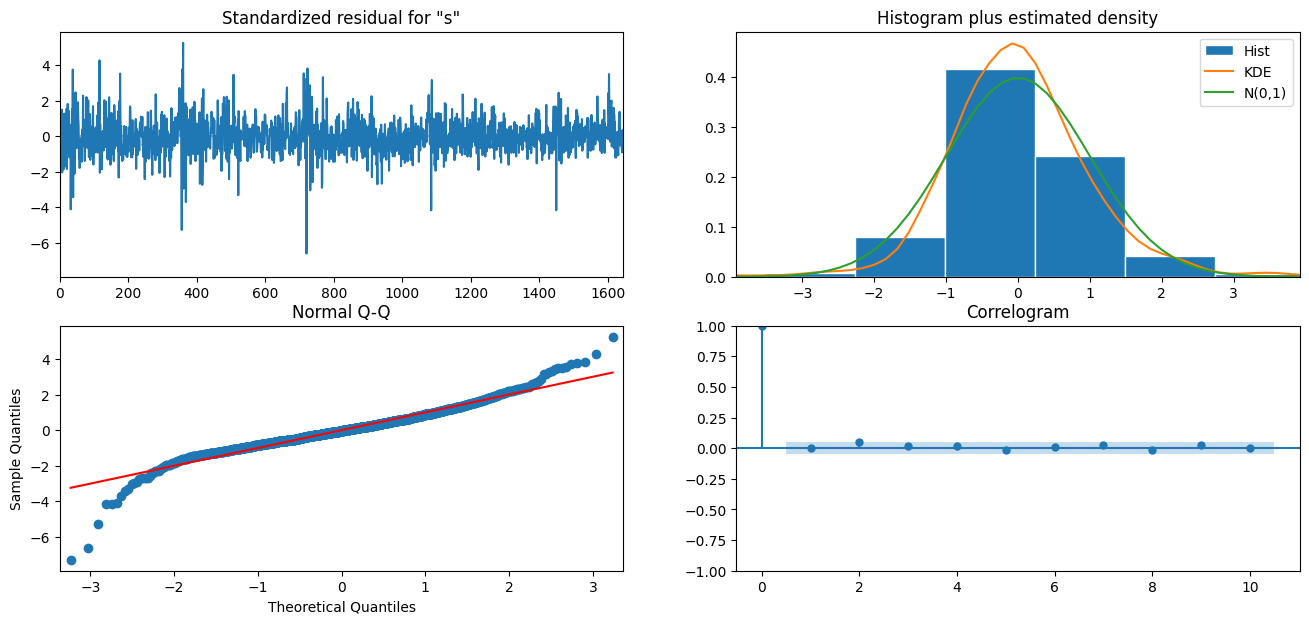

In [31]:
# Plot diagnostics
model_fit.plot_diagnostics(figsize=(16, 7))
plt.show()

# Forecasting

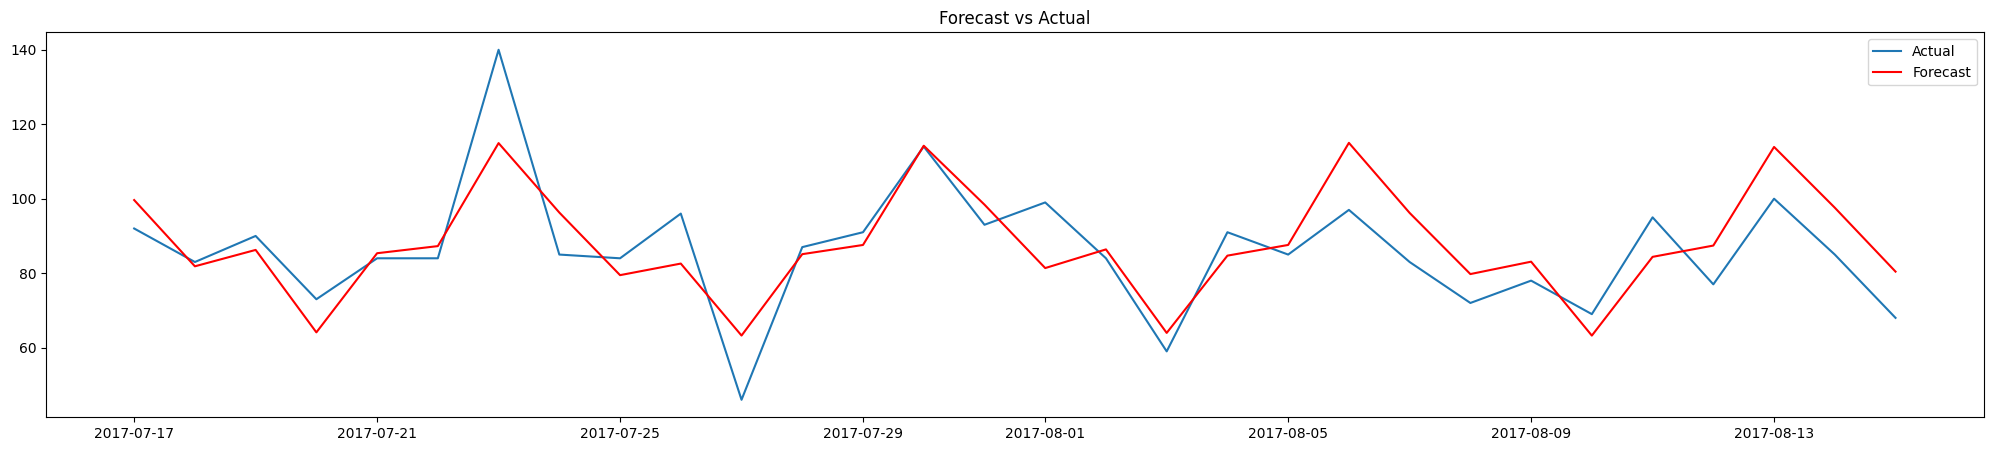

In [32]:
# Prediction
forecast = model_fit.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')
forecast.index = test.index

plt.figure(figsize=(25,5))
plt.title('Forecast vs Actual')
plt.plot(test, label='Actual')
plt.plot(forecast, label='Forecast', color='r')
plt.legend()

plt.show()

In [33]:
forecastSARIMA = pd.DataFrame({'test': test, 'forecast': forecast})
forecastSARIMA

test    forecast
date                         
2017-07-17   92.0   99.639856
2017-07-18   83.0   81.847165
2017-07-19   90.0   86.247566
2017-07-20   73.0   64.104301
2017-07-21   84.0   85.360557
2017-07-22   84.0   87.271598
2017-07-23  140.0  114.933355
2017-07-24   85.0   96.284455
2017-07-25   84.0   79.473082
2017-07-26   96.0   82.580568
2017-07-27   46.0   63.248518
2017-07-28   87.0   85.108043
2017-07-29   91.0   87.577950
2017-07-30  114.0  114.231404
2017-07-31   93.0   98.408553
2017-08-01   99.0   81.373043
2017-08-02   84.0   86.389854
2017-08-03   59.0   63.953920
2017-08-04   91.0   84.711746
2017-08-05   85.0   87.582842
2017-08-06   97.0  115.001078
2017-08-07   83.0   96.183770
2017-08-08   72.0   79.761673
2017-08-09   78.0   83.091148
2017-08-10   69.0   63.237476
2017-08-11   95.0   84.384502
2017-08-12   77.0   87.417615
2017-08-13  100.0  113.907709
2017-08-14   85.0   97.587612
2017-08-15   68.0   80.422052

In [34]:
# model2 = ARIMA(train, order=(9,1,5)) 14903
# model2 = ARIMA(train, order=(6,1,5)) 14970
# model2 = ARIMA(train, order=(9,1,6)) 14900
# model2 = ARIMA(train, order=(9,1,7)) 14769
# model2 = ARIMA(train, order=(9,1,8)) 14768

model2 = ARIMA(train, order=(9,1,8))

model2_fit = model2.fit()
print(model2_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1654
Model:                 ARIMA(9, 1, 8)   Log Likelihood               -7366.311
Date:                Fri, 15 Mar 2024   AIC                          14768.622
Time:                        10:36:30   BIC                          14866.009
Sample:                             0   HQIC                         14804.726
                               - 1654                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5972     15.187     -0.039      0.969     -30.363      29.168
ar.L2         -0.6617     12.459     -0.053      0.958     -25.081      23.757
ar.L3         -0.6466     12.811     -0.050      0.9

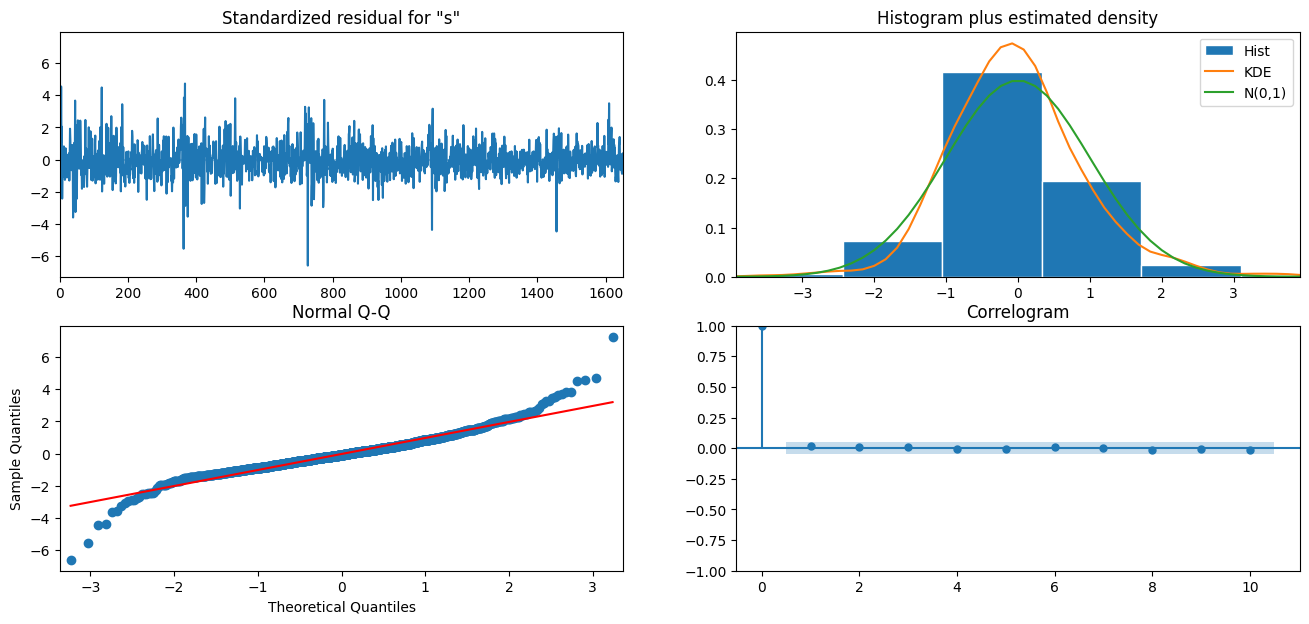

In [35]:
# Plot diagnostics
model2_fit.plot_diagnostics(figsize=(16, 7))
plt.show()

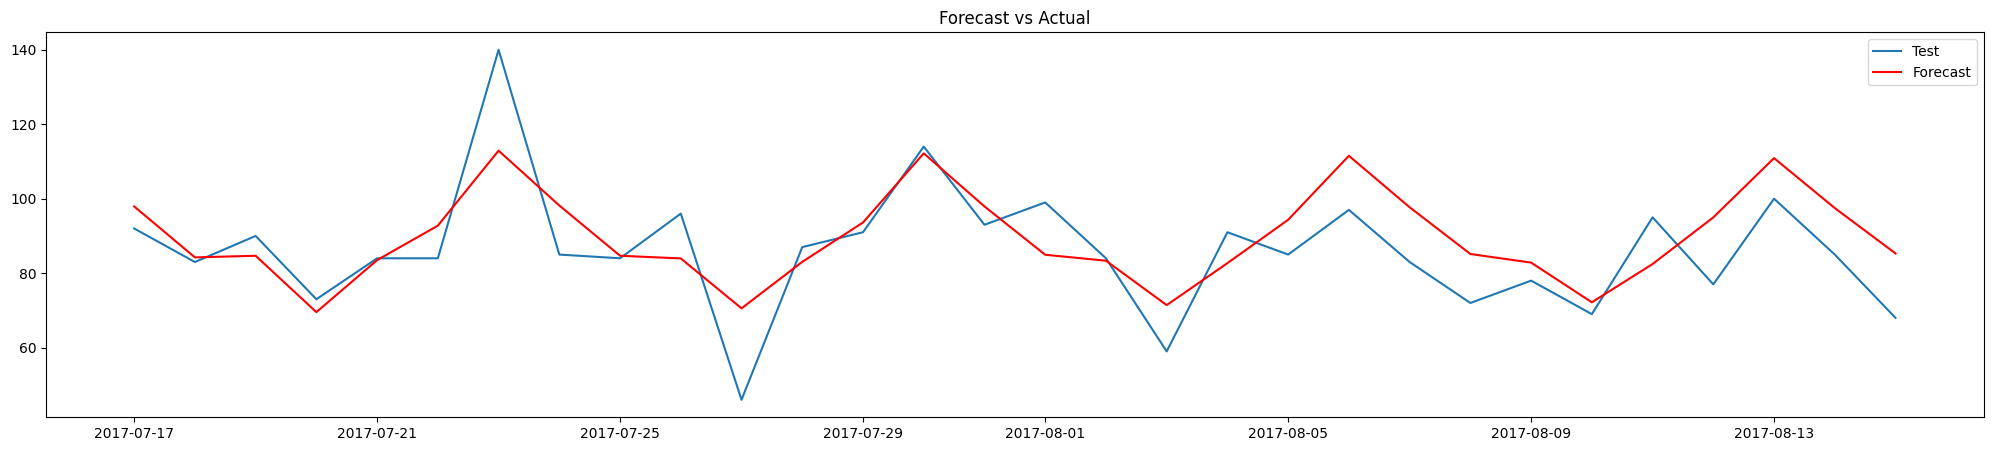

In [36]:
# Prediction
forecast2 = model2_fit.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')
forecast2.index = test.index

plt.figure(figsize=(25,5))
plt.title('Forecast vs Actual')
plt.plot(test, label='Test')
plt.plot(forecast2, label='Forecast', color='r')
plt.legend()

plt.show()

In [37]:
forecastARIMA = pd.DataFrame({'test': test, 'forecast': forecast2})

In [38]:
model = [forecastSARIMA, forecastARIMA]
model_name = ['SARIMA', 'ARIMA']
metrics = []

for i in range(len(model)):
    mae = mean_absolute_error(model[i]['test'], model[i]['forecast'])
    mse = mean_squared_error(model[i]['test'], model[i]['forecast'])
    r2 = r2_score(model[i]['test'], model[i]['forecast'])
    metrics.append([mae, mse, r2])

metrics = pd.DataFrame(metrics, columns=['MAE', 'MSE', 'R2'], index=model_name)
metrics

MAE         MSE        R2
SARIMA  8.405514  106.520453  0.600921
ARIMA   9.414663  135.239082  0.493326

# Membuat Dataframe baru untuk produk Hardware

In [39]:
Hardware = data.loc[data['family'] == 'HARDWARE']
Hardware = Hardware.drop(columns = ['id', 'store_nbr', 'family'])
Hardware['date'] = pd.to_datetime(Hardware['date'])
Hardware = Hardware.set_index('date')

In [40]:
Hardware['year'] = Hardware.index.year
Hardware['month'] = Hardware.index.month
Hardware['week'] = Hardware.index.isocalendar().week
Hardware['day'] = Hardware.index.day
Hardware['day of the week'] = Hardware.index.weekday
Hardware['rolling mean'] = Hardware['sales'].rolling(window=7).mean()
Hardware['rolling std'] = Hardware['sales'].rolling(window=7).std()

In [41]:
Hardware

sales  onpromotion  dcoilwtico  year  month  week  day  \
date                                                                 
2013-01-01    0.0            0       93.14  2013      1     1    1   
2013-01-02    3.0            0       93.14  2013      1     1    2   
2013-01-03    0.0            0       92.97  2013      1     1    3   
2013-01-04    1.0            0       93.12  2013      1     1    4   
2013-01-05    1.0            0       93.12  2013      1     1    5   
...           ...          ...         ...   ...    ...   ...  ...   
2017-08-11    2.0            0       48.81  2017      8    32   11   
2017-08-12    1.0            0       48.81  2017      8    32   12   
2017-08-13    3.0            0       48.81  2017      8    32   13   
2017-08-14    1.0            0       47.59  2017      8    33   14   
2017-08-15    0.0            0       47.57  2017      8    33   15   

            day of the week  rolling mean  rolling std  
date                                                    
2013-01-01                1           NaN          NaN  
2013-01-02                2           NaN          NaN  
2013-01-03                3           NaN          NaN  
2013-01-04                4           NaN          NaN  
2013-01-05                5           NaN          NaN  
...                     ...           ...          ...  
2017-08-11                4      2.142857     1.676163  
2017-08-12                5      2.142857     1.676163  
2017-08-13                6      1.857143     1.214986  
2017-08-14                0      1.857143     1.214986  
2017-08-15                1      1.714286     1.380131  

[1684 rows x 10 columns]

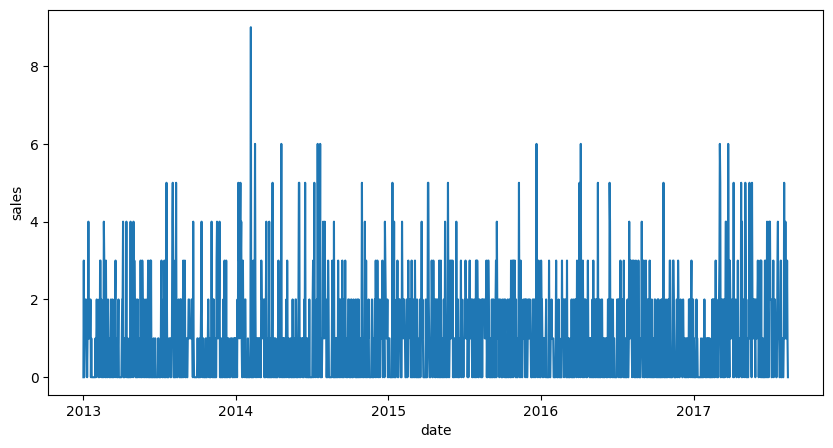

In [42]:
plt.figure(figsize = (10, 5))
sns.lineplot(data = Hardware['sales'])
plt.show()

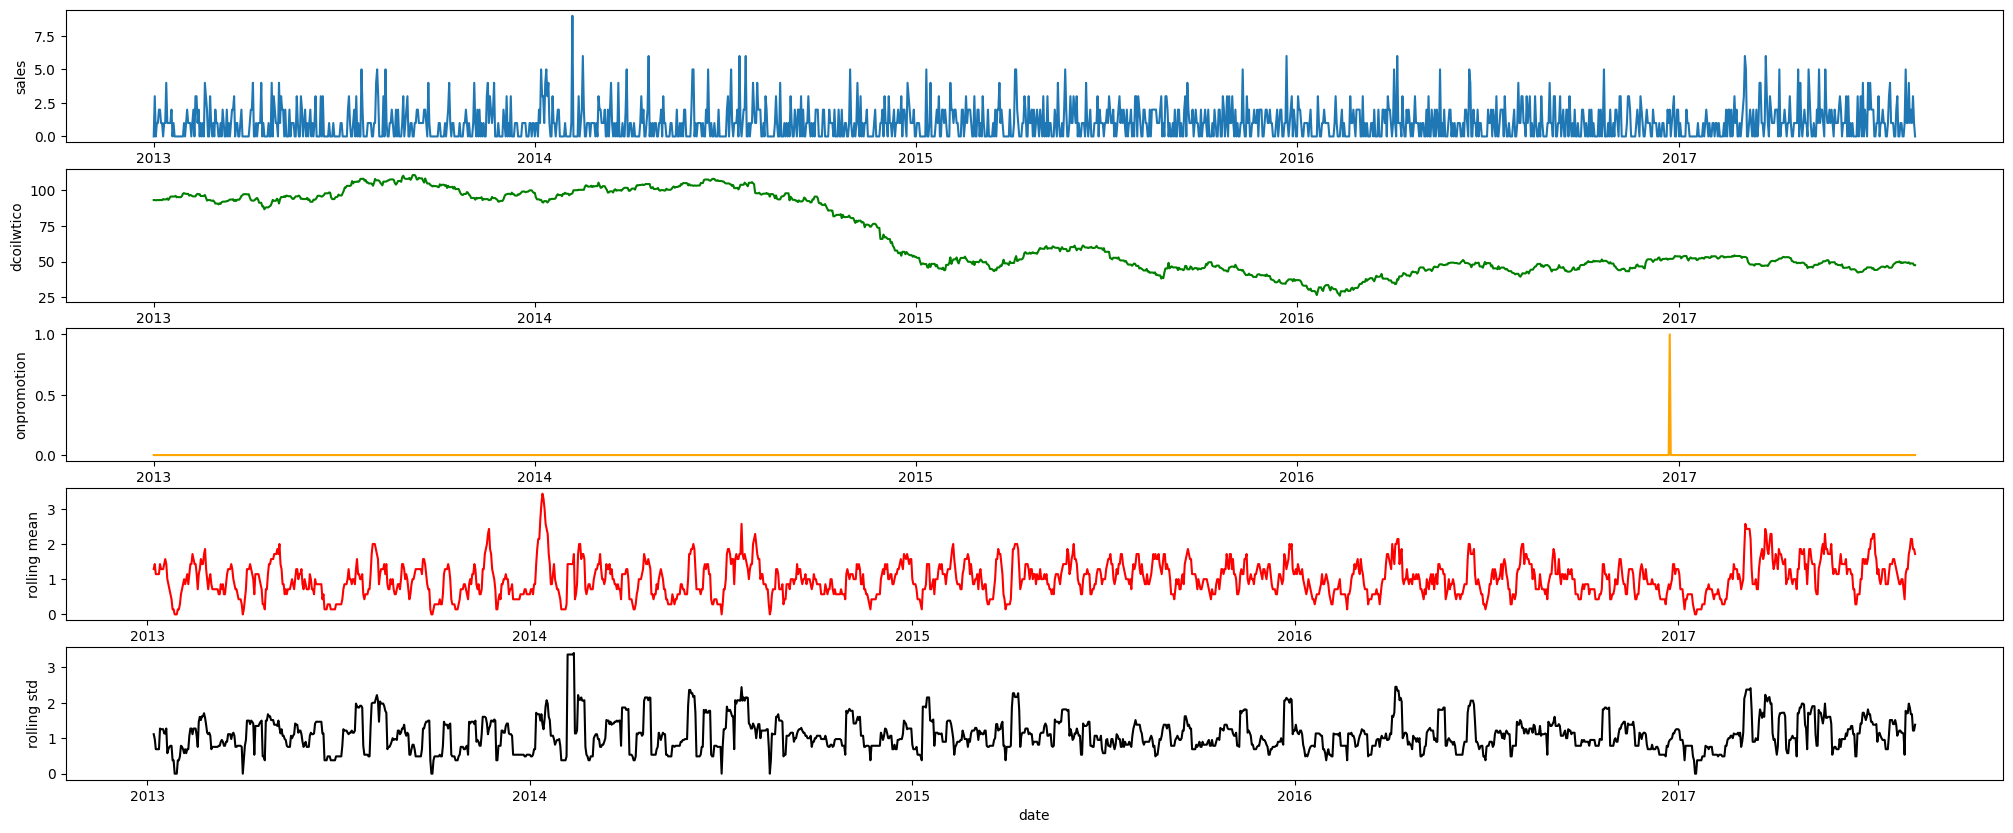

In [43]:
fig, ax = plt.subplots(5, 1, figsize = (25, 10))

sns.lineplot(data=Hardware['sales'], ax=ax[0])
sns.lineplot(data=Hardware['dcoilwtico'], ax=ax[1], color = 'green')
sns.lineplot(data=Hardware['onpromotion'], ax=ax[2], color = 'orange')
sns.lineplot(data=Hardware['rolling mean'], ax=ax[3], color = 'red')
sns.lineplot(data=Hardware['rolling std'], ax=ax[4], color = 'black')

plt.show()

Data cenderung tidak memperlihatkan tren dan terlihat tidak stasioner

In [44]:
Hardware.groupby('day of the week')[['sales']].apply(lambda x: (x == 0).sum())

sales
day of the week       
0                  103
1                  118
2                  109
3                  115
4                  110
5                   86
6                   77

Data memilikki tren naik turun (fluktuatif), dan terdapat season pada produk hardware

Hari yang tidak dapat penjualan hardware paling banyak terjadi pada weekday (senin, rabu) diikuti dengan hari minggu

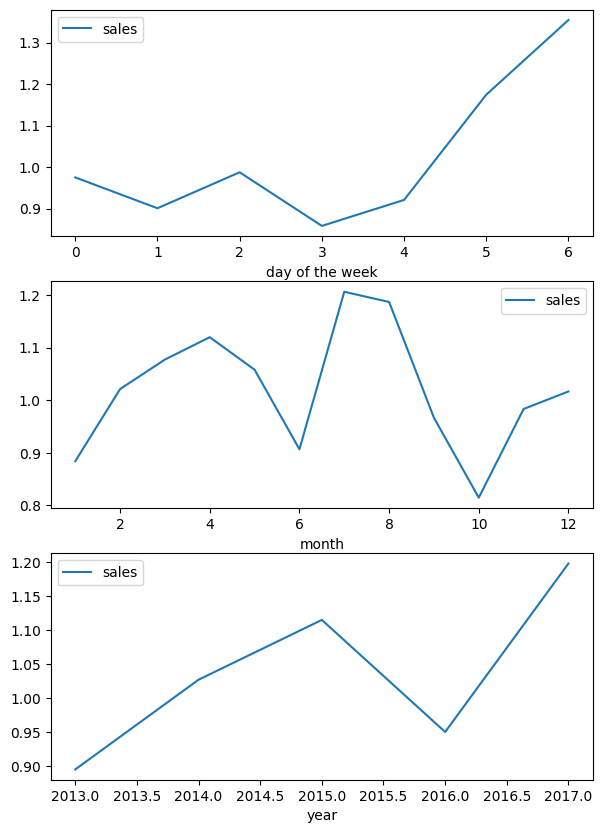

In [45]:
vis1 = Hardware.groupby('day of the week')[['sales']].agg('mean')
vis2 = Hardware.groupby('month')[['sales']].agg('mean')
vis3 = Hardware.groupby('year')[['sales']].agg('mean')

fig, ax = plt.subplots(3, 1, figsize = (7, 10))

sns.lineplot(data = vis1, ax = ax[0])
sns.lineplot(data = vis2, ax = ax[1])
sns.lineplot(data = vis3, ax = ax[2])

plt.show()

<Figure size 2500x1000 with 0 Axes>

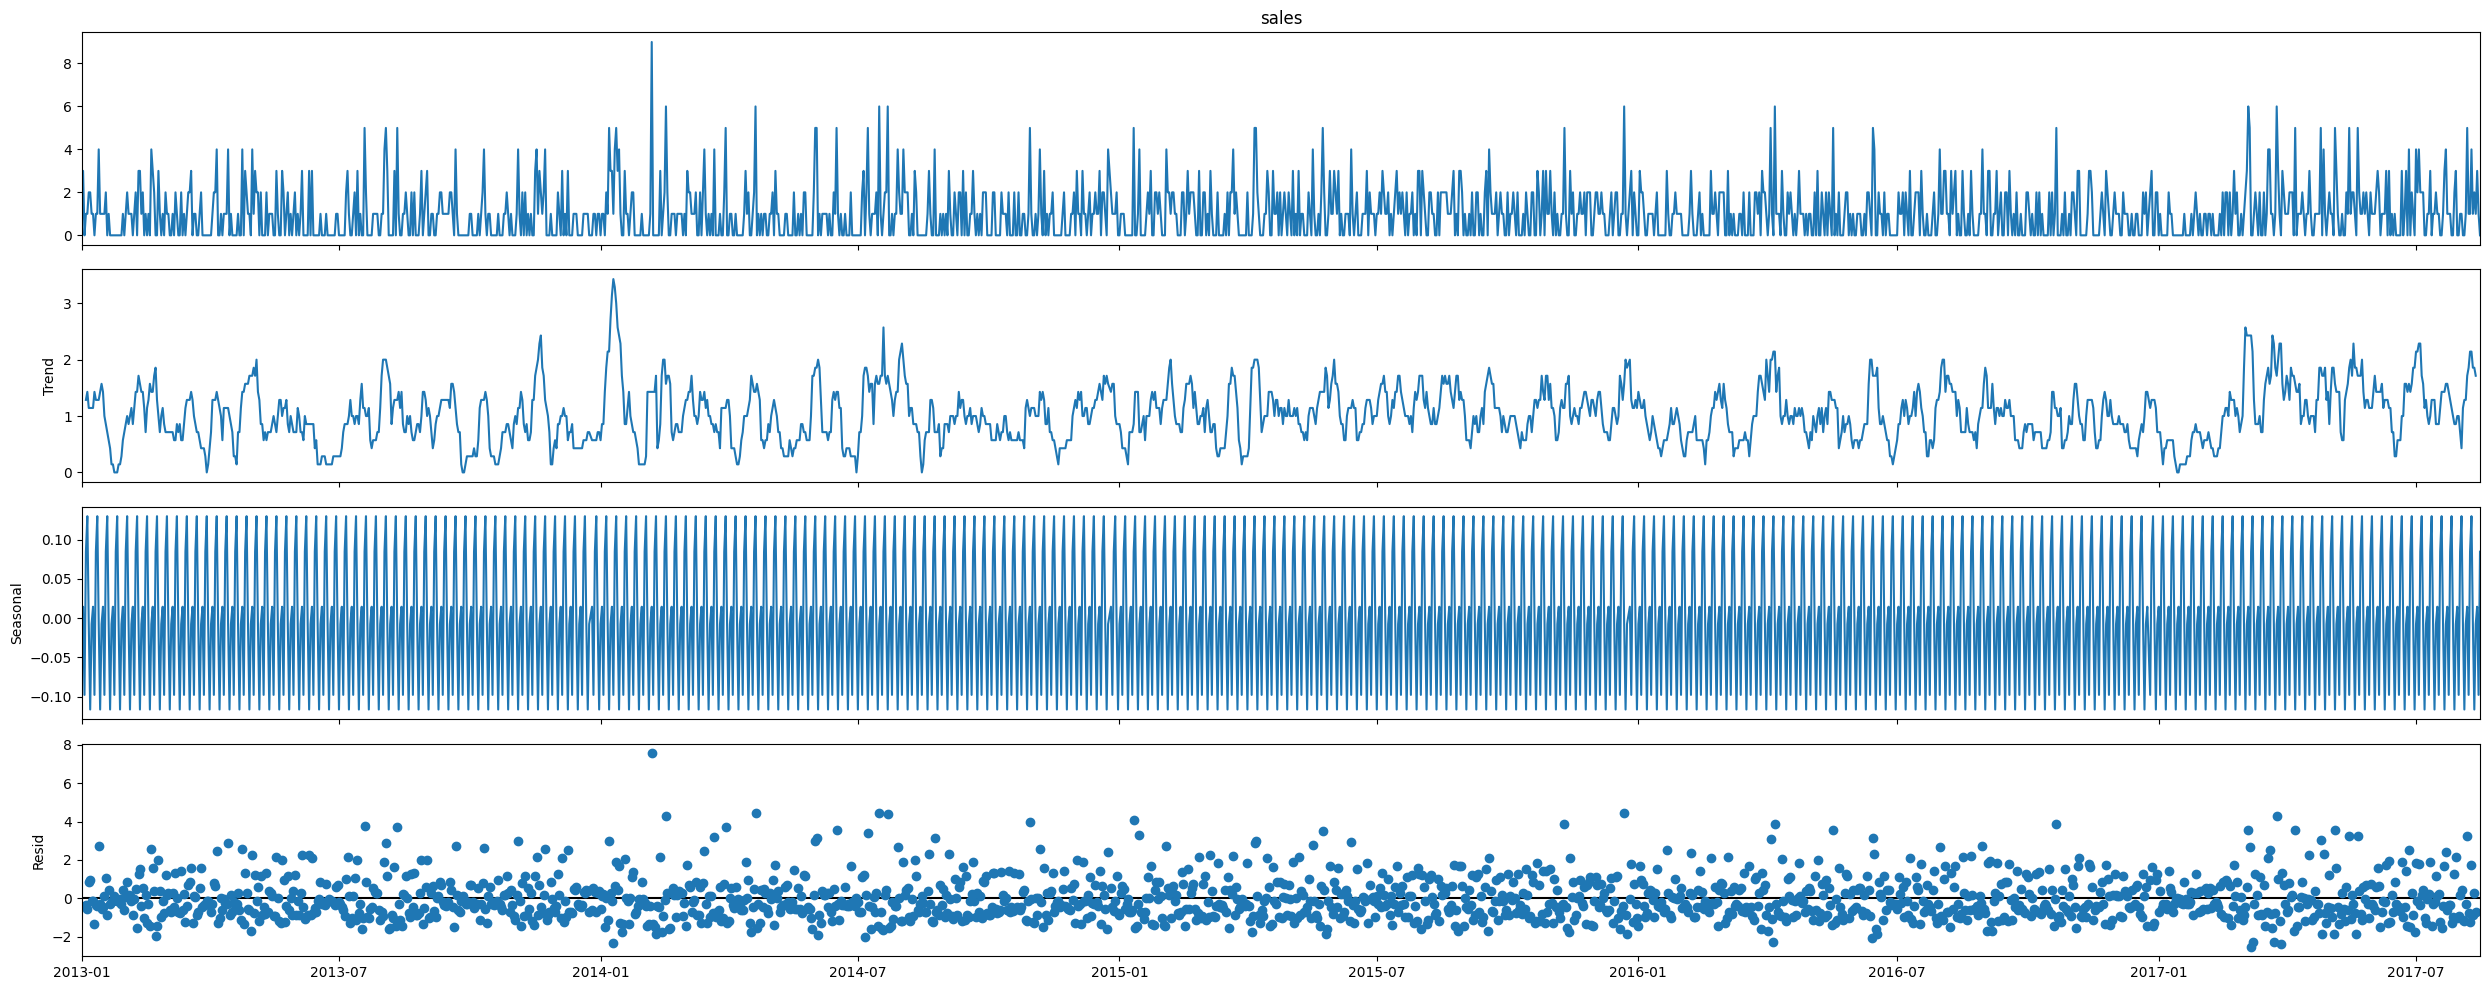

In [62]:
# Make fig size bigger
plt.rcParams['figure.figsize'] = (25, 10)
# Decompose time series
decomposition = seasonal_decompose(Hardware['sales'], model = 'additive', period = 7)
fig = plt.figure()
fig = decomposition.plot()
plt.show()

In [47]:
result = adfuller(Hardware['sales'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -37.858056
p-value: 0.000000


In [48]:
result = kpss(Hardware['sales'])

print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])

KPSS Statistic: 0.411731
p-value: 0.072099


Dari tes ADF dan KPPS dapat disimpulkan bahwa time series bersifat tren stasioner

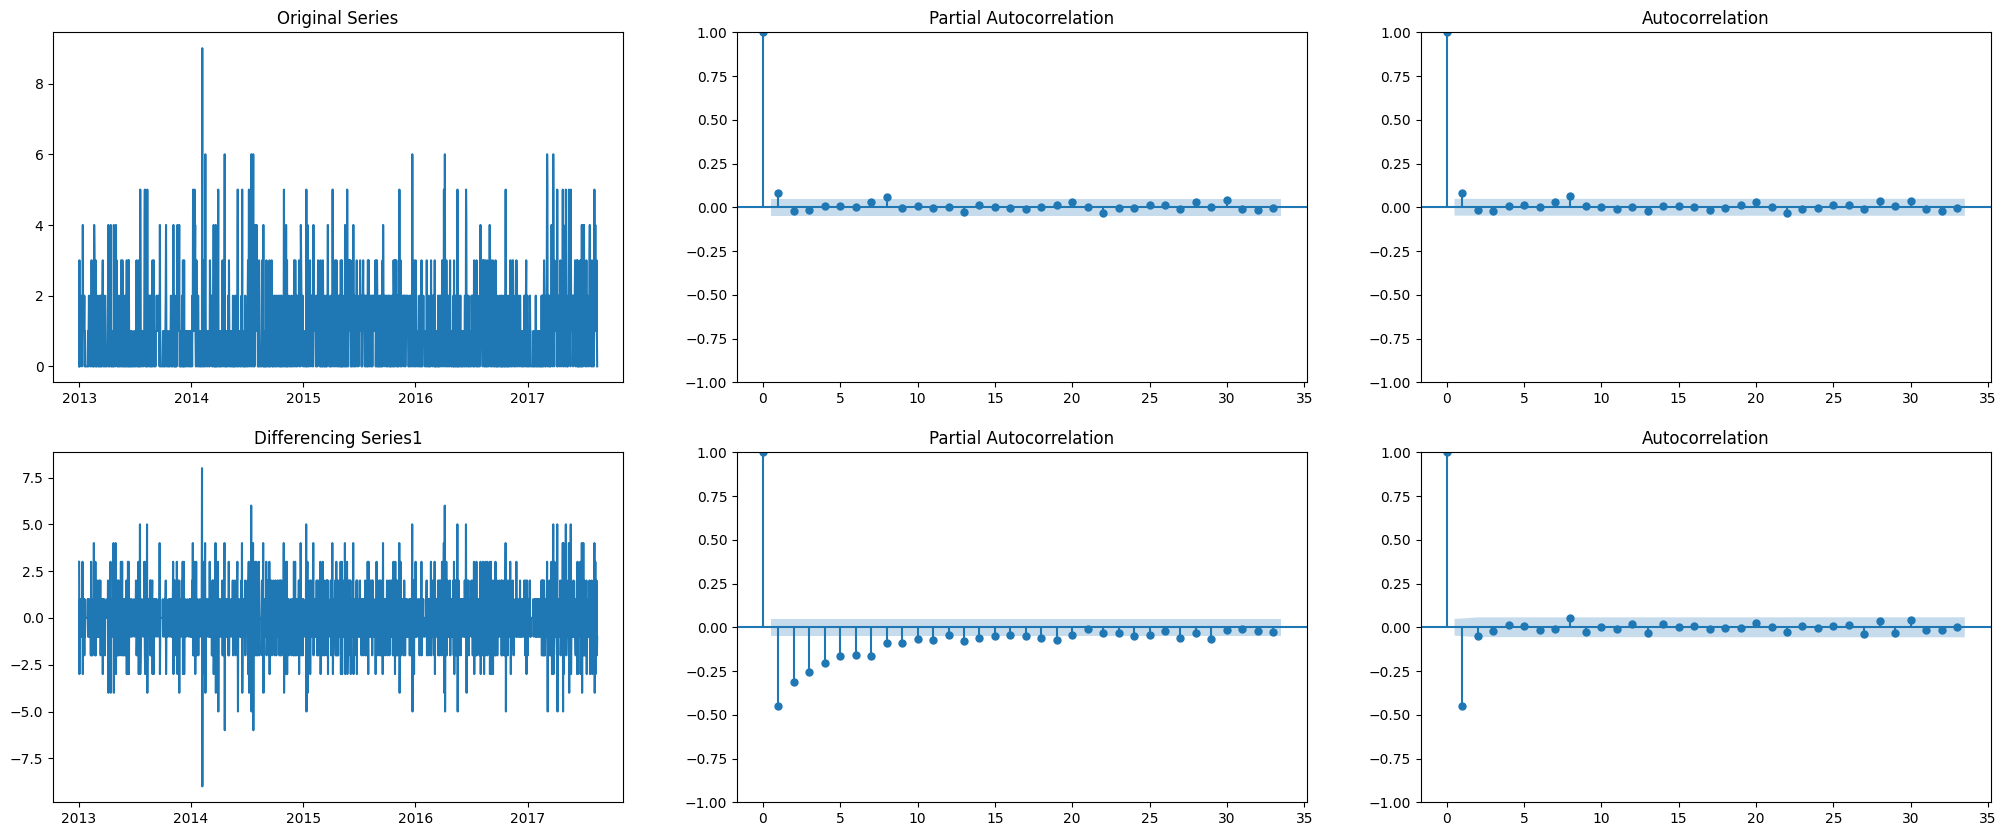

In [49]:
fig, ax = plt.subplots(2, 3, figsize=(25, 10))

ax[0, 0].set_title('Original Series')
ax[0, 0].plot(Hardware['sales'])
ax[0, 1] = plot_pacf(Hardware['sales'], ax=ax[0, 1])
ax[0, 2] = plot_acf(Hardware['sales'], ax=ax[0, 2])

ax[1, 0].set_title('Differencing Series1')
ax[1, 0].plot(Hardware['sales'].diff().dropna())
ax[1, 1] = plot_pacf(Hardware['sales'].diff().dropna(), ax=ax[1, 1])
ax[1, 2] = plot_acf(Hardware['sales'].diff().dropna(), ax=ax[1, 2])

plt.show()

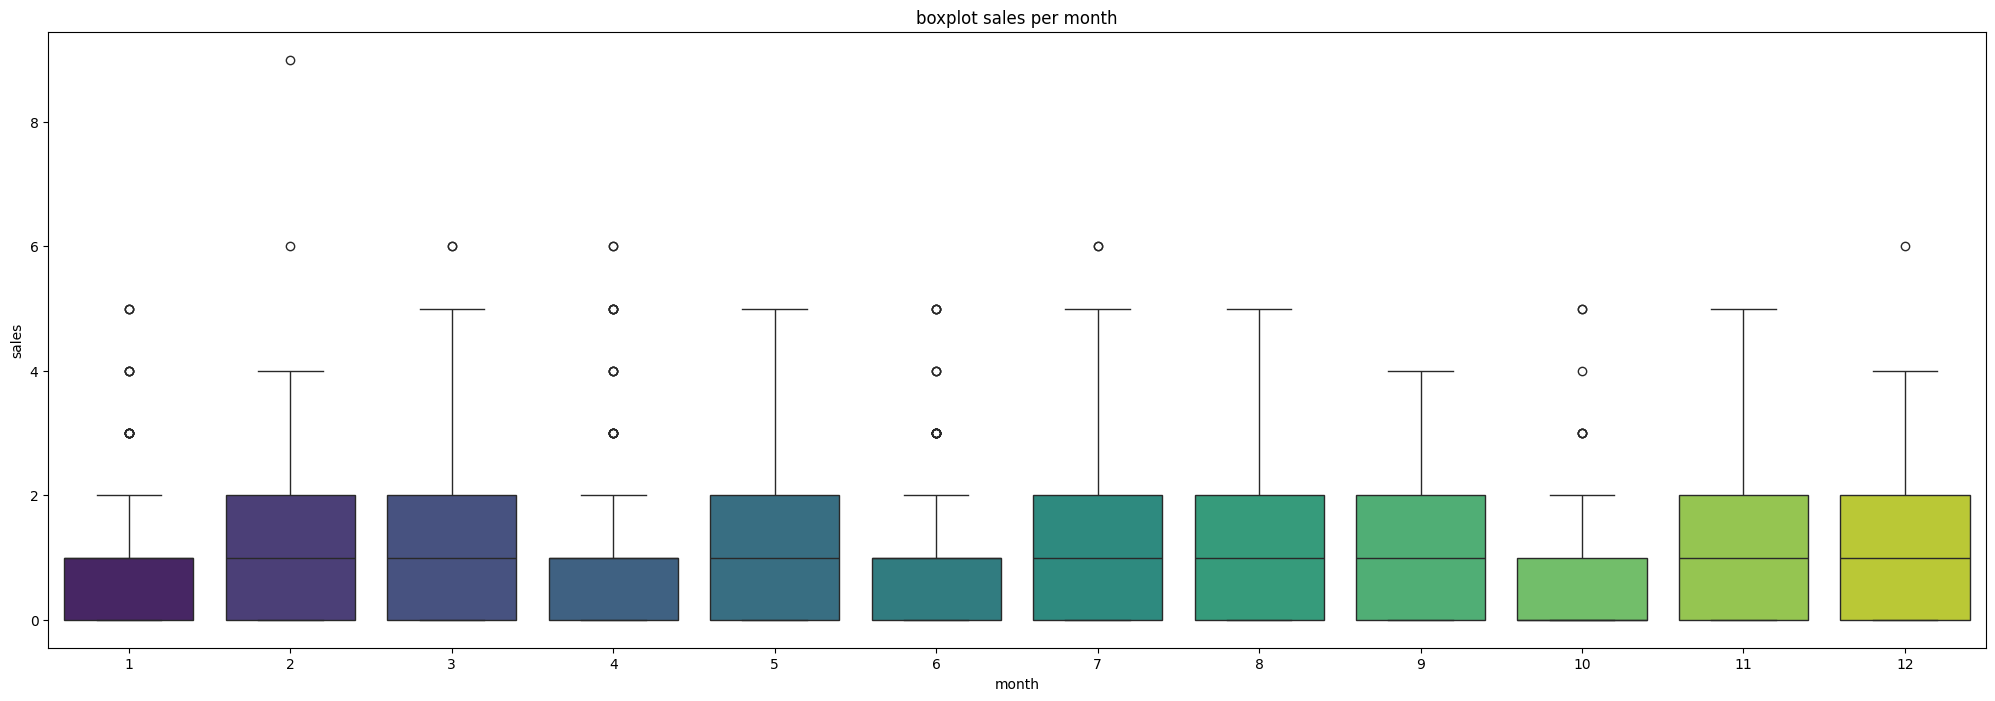

In [50]:
plt.figure(figsize = (25, 8))

sns.boxplot(data = Hardware, x = 'month', y = 'sales', palette = 'viridis')
plt.title('boxplot sales per month')
plt.show()

- Outlier terlihat berada di luar batas atas
- Distribusi Data terlihat cenderung positive skewed pada setiap bulannya

In [68]:
# model = ARIMA(train, order=(1,0,1)) 15944
# model = ARIMA(train, order=(1,1,1)) 15658
# model = ARIMA(train, order=(2,1,1)) 15601
# model = ARIMA(train, order=(3,1,1)) 15496
# model = ARIMA(train, order=(11,1,1)) 14998
# model = ARIMA(train, order=(12,1,1)) 14984
# model = ARIMA(train, order=(20,1,2)) 14882
# model = ARIMA(train, order=(20,1,8)) 14815
# model = ARIMA(train, order=(21,1,8)) 14812
# model = ARIMA(train, order=(22,1,9)) 14807
# model = ARIMA(train, order=(21,1,10)) 14803
# model = ARIMA(train, order=(21,1,11)) 14801
# model = ARIMA(train, order=(16,1,8)) 14789
# model = ARIMA(train, order=(12,1,8)) 14775
# model = ARIMA(train, order=(11,1,8))14774
# model = ARIMA(train, order=(10,1,8)) 14770
# model = ARIMA(train, order=(9,1,8)) 14768
# model = ARIMA(train, order=(8,1,8)) 14766
# model = ARIMA(train, order=(7,1,8)) 14764

modell = ARIMA(train, order=(7,1,8))
modell_fit = modell.fit()
print(modell_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1654
Model:                 ARIMA(7, 1, 8)   Log Likelihood               -7366.399
Date:                Fri, 15 Mar 2024   AIC                          14764.798
Time:                        17:07:41   BIC                          14851.364
Sample:                             0   HQIC                         14796.890
                               - 1654                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5857      0.187     -3.130      0.002      -0.952      -0.219
ar.L2         -0.6079      0.186     -3.277      0.001      -0.971      -0.244
ar.L3         -0.5993      0.187     -3.208      0.0

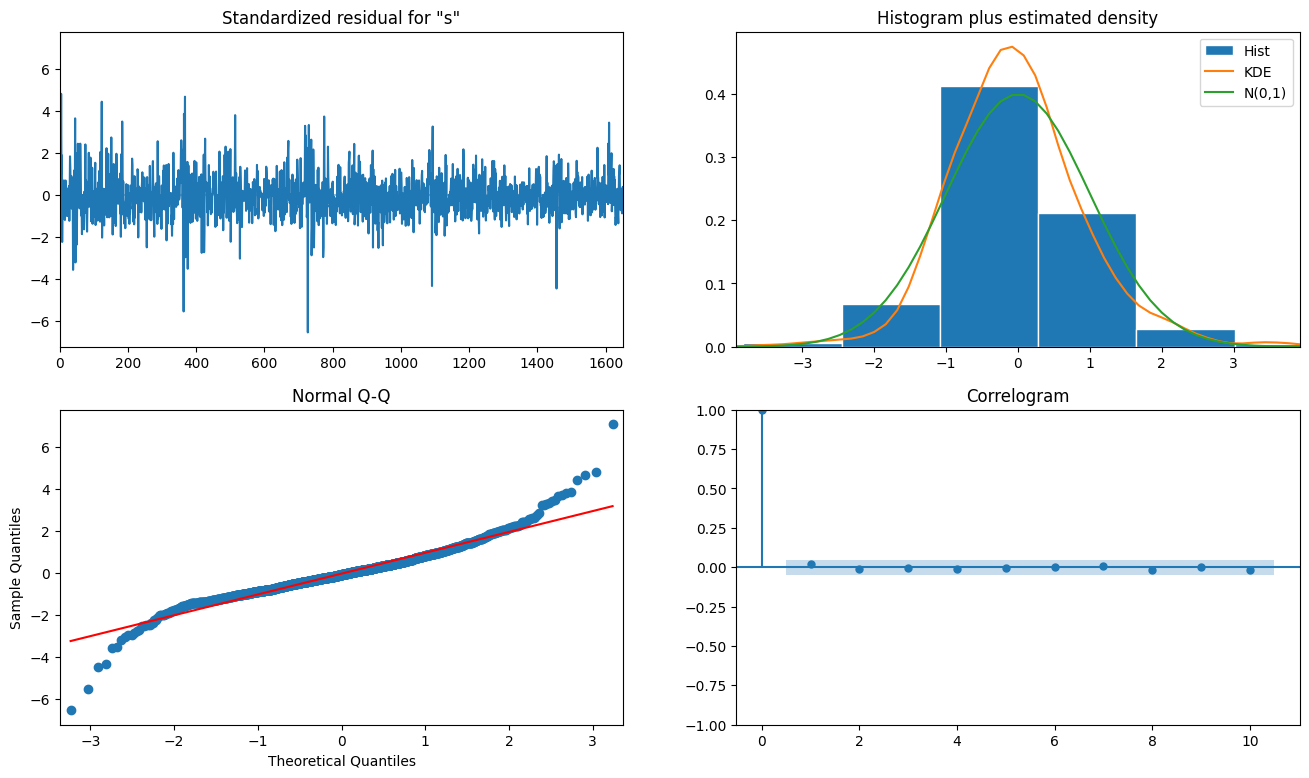

In [69]:
# Plot diagnostics
modell_fit.plot_diagnostics(figsize=(16, 9))
plt.show()

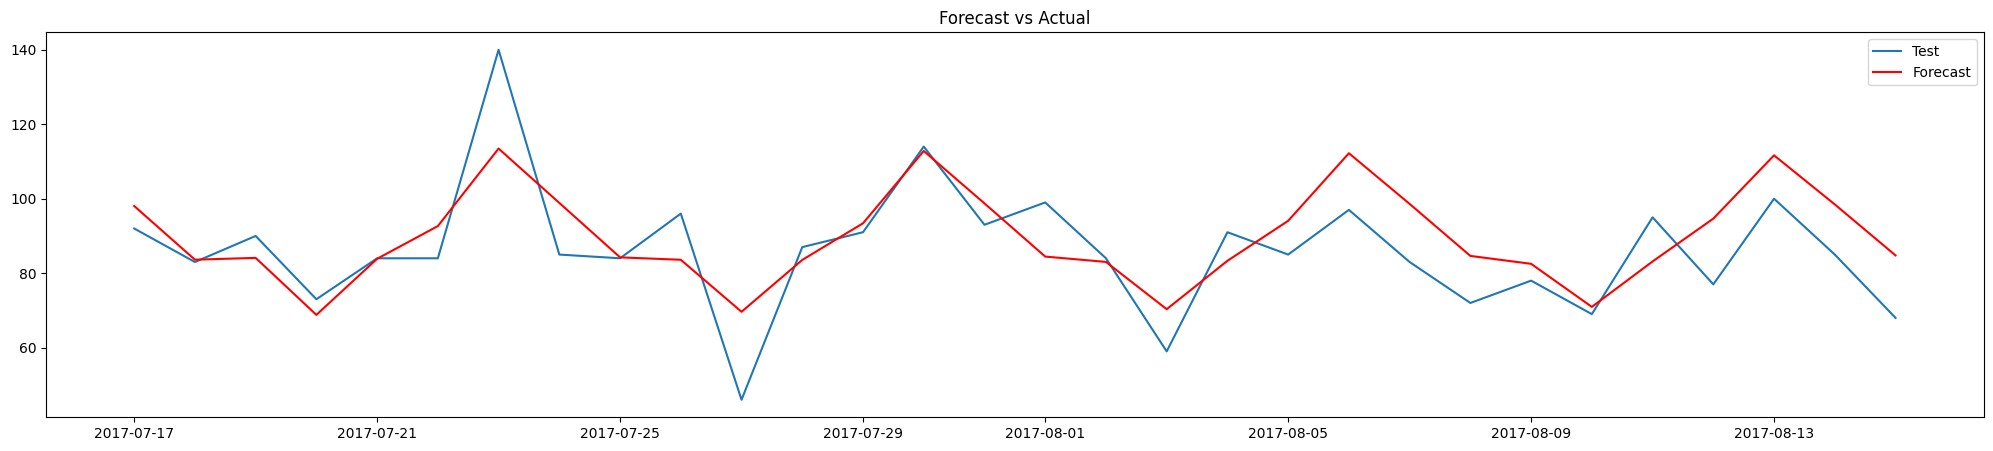

In [70]:
# Prediction
forecastt = modell_fit.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')
forecastt.index = test.index

plt.figure(figsize=(25,5))
plt.title('Forecast vs Actual')
plt.plot(test, label='Test')
plt.plot(forecastt, label='Forecast', color='r')
plt.legend()

plt.show()

In [71]:
forecastARIMA = pd.DataFrame({'test': test, 'forecast': forecastt})

In [72]:
model = [forecastARIMA]
model_name = ['ARIMA']
metrics = []

for i in range(len(model)):
    mae = mean_absolute_error(model[i]['test'], model[i]['forecast'])
    mse = mean_squared_error(model[i]['test'], model[i]['forecast'])
    r2 = r2_score(model[i]['test'], model[i]['forecast'])
    metrics.append([mae, mse, r2])

metrics = pd.DataFrame(metrics, columns=['MAE', 'MSE', 'R2'], index=model_name)
metrics

MAE         MSE        R2
ARIMA  9.329832  133.871691  0.498449